# SYSTEM CHECK

In [ ]:
import os
import numpy as np
import pandas as pd
import ast
import torch
import PIL
from tqdm.auto import tqdm
import shutil as sh
from pathlib import Path
import random

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')
print(gpus)
print(cpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Choose your device for computation. CPU or one of your CUDA devices.

In [ ]:
tf.config.set_visible_devices(gpus, 'GPU')

Import of files from my google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!mkdir OpenImages

In [ ]:
!mkdir /content/gdrive/MyDrive/OpenImages

In [ ]:
%cd /content/gdrive/MyDrive/OpenImages


/content/gdrive/MyDrive/OpenImages


In [ ]:
!pwd

/content/gdrive/MyDrive/OpenImages


# Import of annotation from OpenImages website


In [ ]:
# Download required meta-files
!wget https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv

!wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

!wget https://storage.googleapis.com/openimages/2018_04/validation/validation-annotations-bbox.csv

!wget https://storage.googleapis.com/openimages/2018_04/test/test-annotations-bbox.csv

--2023-07-03 11:12:36--  https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.31.128, 142.251.18.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11255 (11K) [text/csv]
Saving to: ‘class-descriptions-boxable.csv’

class-descriptions- 100%[===================>]  10.99K  --.-KB/s    in 0.001s  

2023-07-03 11:12:37 (10.8 MB/s) - ‘class-descriptions-boxable.csv’ saved [11255/11255]

--2023-07-03 11:12:37--  https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.31.128, 142.251.18.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1194033454 (1.1G)

In [ ]:
!pip install awscli

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 100.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 22.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for PyYAML: filename=PyYAML-5.4.1-cp310-cp310-linux_x86_64.whl size=45658 sha256=24647bec86bb2c69b1d3c056913d3998ab009c6efe393ed5358444489cb1298e
  Stored in directory: /root/.cache/pip/wheels/c7/0d/22/696ee92245ad710f506eee79bb05c740d8abccd3ecdb778683
Successfully built PyYAML
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Succ

In [ ]:
#This magic function is used to create the files.downloadOI.py is the file name
%%writefile downloadOI.py

#### Usage example: python3 downloadOI.py --classes 'Aircraft,Airplane' --mode train

import argparse
import csv
import subprocess
import os
from tqdm import tqdm
import multiprocessing
from multiprocessing import Pool as thread_pool

cpu_count = multiprocessing.cpu_count()

parser = argparse.ArgumentParser(description='Download Class specific images from OpenImagesV4')
parser.add_argument("--mode", help="Dataset category - train, validation or test", required=True)
parser.add_argument("--classes", help="Names of object classes to be downloaded", required=True)
parser.add_argument("--nthreads", help="Number of threads to use", required=False, type=int, default=cpu_count*2)
parser.add_argument("--occluded", help="Include occluded images", required=False, type=int, default=1)
parser.add_argument("--truncated", help="Include truncated images", required=False, type=int, default=1)
parser.add_argument("--groupOf", help="Include groupOf images", required=False, type=int, default=1)
parser.add_argument("--depiction", help="Include depiction images", required=False, type=int, default=1)
parser.add_argument("--inside", help="Include inside images", required=False, type=int, default=1)

args = parser.parse_args()

run_mode = args.mode

threads = args.nthreads

classes = []
for class_name in args.classes.split(','):
    classes.append(class_name)

with open('./class-descriptions-boxable.csv', mode='r') as infile:
    reader = csv.reader(infile)
    dict_list = {rows[1]:rows[0] for rows in reader}

subprocess.run(['rm', '-rf', run_mode])
subprocess.run([ 'mkdir', run_mode])

pool = thread_pool(threads)
commands = []
cnt = 0

for ind in range(0, len(classes)):

    class_name = classes[ind]
    print("Class "+str(ind) + " : " + class_name)

    subprocess.run([ 'mkdir', run_mode+'/'+class_name])

    command = "grep "+dict_list[class_name.replace('_', ' ')] + " ./" + run_mode + "-annotations-bbox.csv"
    class_annotations = subprocess.run(command.split(), stdout=subprocess.PIPE).stdout.decode('utf-8')
    class_annotations = class_annotations.splitlines()

    for line in class_annotations:

        line_parts = line.split(',')

        #IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
        if (args.occluded==0 and int(line_parts[8])>0):
            print("Skipped %s",line_parts[0])
            continue
        if (args.truncated==0 and int(line_parts[9])>0):
            print("Skipped %s",line_parts[0])
            continue
        if (args.groupOf==0 and int(line_parts[10])>0):
            print("Skipped %s",line_parts[0])
            continue
        if (args.depiction==0 and int(line_parts[11])>0):
            print("Skipped %s",line_parts[0])
            continue
        if (args.inside==0 and int(line_parts[12])>0):
            print("Skipped %s",line_parts[0])
            continue

        cnt = cnt + 1

        command = 'aws s3 --no-sign-request --only-show-errors cp s3://open-images-dataset/'+run_mode+'/'+line_parts[0]+'.jpg '+ run_mode+'/'+class_name+'/'+line_parts[0]+'.jpg'
        commands.append(command)

        with open('%s/%s/%s.txt'%(run_mode,class_name,line_parts[0]),'a') as f:
            f.write(','.join([class_name, line_parts[4], line_parts[5], line_parts[6], line_parts[7]])+'\n')

print("Annotation Count : "+str(cnt))
commands = list(set(commands))
print("Number of images to be downloaded : "+str(len(commands)))

list(tqdm(pool.imap(os.system, commands), total = len(commands) ))

pool.close()
pool.join()

Writing downloadOI.py


#Download of image of Aircraft and Airplane from Open images.

In [ ]:
# Download Sink and Toilet images for test
!python3 downloadOI.py --classes "Aircraft,Airplane" --mode test
# Download Sink and Toilet images for train
!python3 downloadOI.py --classes "Aircraft,Airplane" --mode train
# Download Sink and Toilet images for validation
!python3 downloadOI.py --classes "Aircraft,Airplane" --mode validation

Class 0 : Aircraft
Class 1 : Airplane
Annotation Count : 3828
Number of images to be downloaded : 2875
100% 2875/2875 [25:50<00:00,  1.85it/s]
Class 0 : Aircraft
Class 1 : Airplane
Annotation Count : 23183
Number of images to be downloaded : 13146
100% 13146/13146 [1:58:12<00:00,  1.85it/s]
Class 0 : Aircraft
Class 1 : Airplane
Annotation Count : 1213
Number of images to be downloaded : 905
100% 905/905 [08:10<00:00,  1.85it/s]


In [ ]:
!ls /content/gdrive/MyDrive/OpenImages

class-descriptions-boxable.csv	test-annotations-bbox.csv
dataset				train
data.yaml			train-annotations-bbox.csv
downloadOI.py			validation
final-airplane--1		validation-annotations-bbox.csv
input				yolov8n.pt
runs				yolov8s.pt
test


In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()
!yolo checks

Ultralytics YOLOv8.1.1 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)

OS                  Linux-6.1.58+-x86_64-with-glibc2.35
Environment         Colab
Python              3.10.12
Install             pip
RAM                 12.67 GB
CPU                 Intel Xeon 2.20GHz
CUDA                12.1

matplotlib          ✅ 3.7.1>=3.3.0
numpy               ✅ 1.23.5>=1.22.2
opencv-python       ✅ 4.8.0.76>=4.6.0
pillow              ✅ 9.4.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.31.0>=2.23.0
scipy               ✅ 1.11.4>=1.4.1
torch               ✅ 2.1.0+cu121>=1.8.0
torchvision         ✅ 0.16.0+cu121>=0.9.0
tqdm                ✅ 4.66.1>=4.64.0
psutil              ✅ 5.9.5
py-cpuinfo          ✅ 9.0.0
thop                ✅ 0.1.1-2209072238>=0.1.1
pandas              ✅ 1.5.3>=1.1.4
seaborn             ✅ 0.12.2>=0.11.0
hub-sdk             ✅ 0.0.3>=0.0.2


In [ ]:
DATA_DIR = Path('/content/gdrive/MyDrive/OpenImages/final-airplane--1/')
images_dir = DATA_DIR / 'train/images'

if not DATA_DIR.exists():
    print(f"ERROR: {DATA_DIR} does not exist.")
elif not images_dir.exists():
    print(f"ERROR: {images_dir} does not exist.")
else:
    img_list = list(images_dir.glob('*.jpg'))
    if len(img_list) == 0:
        print("ERROR: No image files found in the 'images' directory.")
    else:
        pickone = random.choice(img_list)
        display.Image(pickone)


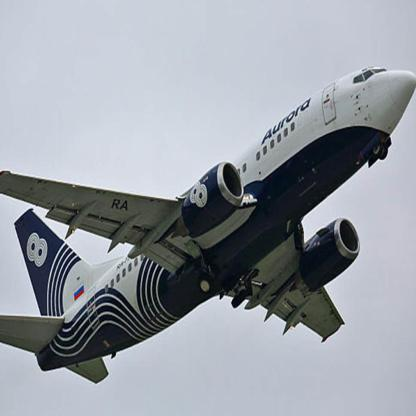

In [ ]:
DATA_DIR = Path('/content/gdrive/MyDrive/OpenImages/final-airplane--1/')
img_list = list(DATA_DIR.glob('train/images/*.jpg'))
pickone = random.choice(img_list)
display.Image(pickone)

In [ ]:
print(f"Found {len(img_list)} images files in {DATA_DIR}")

img = PIL.Image.open(pickone)
IMAGE_HEIGHT, IMAGE_WIDTH = img.size
num_channels = len(img.mode)
print("Image size: {}".format((IMAGE_HEIGHT, IMAGE_WIDTH)))
print("Num channels: {}".format(num_channels))

Found 1305 images files in /content/gdrive/MyDrive/OpenImages/final-airplane--1
Image size: (416, 416)
Num channels: 3


In [ ]:
DATA_DIR1 = Path('/content/gdrive/MyDrive/OpenImages')
df = pd.read_csv(DATA_DIR1 / 'train-annotations-bbox.csv')
# convert a string record into a valid python object
def f(x):
    return ast.literal_eval(x.rstrip('\r\n'))

df = pd.read_csv(DATA_DIR1 / "train-annotations-bbox.csv",
                converters={'geometry': f})
df.head(10)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0
5,000002b66c9c498e,xclick,/m/01g317,1,0.320312,0.368750,0.260938,0.328125,1,0,0,0,0
6,000002b66c9c498e,xclick,/m/01g317,1,0.412500,0.945312,0.120312,0.475000,1,0,1,0,0
7,000002b66c9c498e,xclick,/m/0284d,1,0.528125,0.923437,0.675000,0.964063,0,0,0,0,0
8,000002b66c9c498e,xclick,/m/04bcr3,1,0.064062,0.492188,0.889063,0.993750,0,0,0,0,0
9,000002b66c9c498e,xclick,/m/04bcr3,1,0.301562,0.990625,0.462500,0.595312,0,0,0,0,0


In [ ]:
DATA_DIR2 = Path('/content/gdrive/MyDrive/OpenImages')
df = pd.read_csv(DATA_DIR2 / 'validation-annotations-bbox.csv')
# convert a string record into a valid python object
def f(x):
    return ast.literal_eval(x.rstrip('\r\n'))

df = pd.read_csv(DATA_DIR2 / "validation-annotations-bbox.csv",
                converters={'geometry': f})
df.head(10)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,0001eeaf4aed83f9,freeform,/m/0cmf2,1,0.022464,0.964178,0.070656,0.800164,0,0,0,0,0
1,000595fe6fee6369,freeform,/m/02wbm,1,0.000000,1.000000,0.000233,1.000000,0,0,1,0,0
2,000595fe6fee6369,freeform,/m/02xwb,1,0.141030,0.180277,0.676262,0.732455,0,0,0,0,0
3,000595fe6fee6369,freeform,/m/02xwb,1,0.213781,0.253028,0.298764,0.354956,1,0,0,0,0
4,000595fe6fee6369,freeform,/m/02xwb,1,0.232926,0.288447,0.488954,0.545146,1,0,0,0,0
5,000595fe6fee6369,freeform,/m/02xwb,1,0.245370,0.290361,0.661854,0.716605,1,0,0,0,0
6,000595fe6fee6369,freeform,/m/02xwb,1,0.245370,0.291319,0.548028,0.604220,1,0,0,0,0
7,000595fe6fee6369,freeform,/m/02xwb,1,0.247285,0.283661,0.379450,0.437084,1,0,0,0,0
8,000595fe6fee6369,freeform,/m/02xwb,1,0.247285,0.294190,0.608543,0.673380,1,0,0,0,0
9,000595fe6fee6369,freeform,/m/02xwb,1,0.271216,0.306635,0.597016,0.658972,1,0,0,0,0


In [ ]:
DATA_DIR3 = Path('/content/gdrive/MyDrive/OpenImages')
df = pd.read_csv(DATA_DIR3 / 'test-annotations-bbox.csv')
# convert a string record into a valid python object
def f(x):
    return ast.literal_eval(x.rstrip('\r\n'))

df = pd.read_csv(DATA_DIR3 / "test-annotations-bbox.csv",
                converters={'geometry': f})
df.head(10)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000026e7ee790996,freeform,/m/07j7r,1,0.071905,0.145346,0.206591,0.391306,0,1,1,0,0
1,000026e7ee790996,freeform,/m/07j7r,1,0.439756,0.572466,0.264153,0.435122,0,1,1,0,0
2,000026e7ee790996,freeform,/m/07j7r,1,0.668455,1.000000,0.000000,0.552825,0,1,1,0,0
3,000062a39995e348,freeform,/m/015p6,1,0.205719,0.849912,0.154144,1.000000,0,0,0,0,0
4,000062a39995e348,freeform,/m/05s2s,1,0.137133,0.377634,0.000000,0.884185,1,1,0,0,0
5,0000c64e1253d68f,freeform,/m/07yv9,1,0.000000,0.973850,0.000000,0.043342,0,1,1,0,0
6,0000c64e1253d68f,freeform,/m/0k4j,1,0.000000,0.513534,0.321356,0.689661,0,1,0,0,0
7,0000c64e1253d68f,freeform,/m/0k4j,1,0.016515,0.268228,0.299368,0.462906,1,0,0,0,0
8,0000c64e1253d68f,freeform,/m/0k4j,1,0.481498,0.904376,0.232029,0.489017,1,0,0,0,0
9,0000c64e1253d68f,freeform,/m/0k4j,1,0.751517,1.000000,0.332350,0.658053,0,1,0,0,0


#Training

In [ ]:
HOME = "/content/gdrive/MyDrive/OpenImages/final-airplane--1/"
!yolo task=detect mode=train model=yolov8s.pt data={HOME}/data.yaml epochs=500 imgsz=416

Ultralytics YOLOv8.0.141 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/gdrive/MyDrive/OpenImages/final-airplane--1//data.yaml, epochs=500, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, op

# Validation

In [ ]:

!yolo task=detect mode=val model=/content/gdrive/MyDrive/OpenImages/runs/detect/train2/weights/best.pt data=/content/gdrive/MyDrive/OpenImages/final-airplane--1/data.yaml

Ultralytics YOLOv8.0.141 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients
val: Scanning /content/gdrive/MyDrive/OpenImages/final-airplane--1/valid/labels.cache... 269 images, 0 backgrounds, 0 corrupt: 100% 269/269 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 17/17 [00:05<00:00,  3.12it/s]
                   all        269        287      0.923      0.872      0.942      0.734
Speed: 1.0ms preprocess, 5.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val4


In [ ]:
!ls /content/gdrive/MyDrive/OpenImages/final-airplane--1/runs/detect/train

weights


Listing of all the training and validtion elements(F1-score, Confusion matrix...)

In [ ]:
!ls /content/gdrive/MyDrive/MasterProject/runs/detect/train/

args.yaml					    results.png
confusion_matrix_normalized.png			    train_batch0.jpg
confusion_matrix.png				    train_batch1.jpg
events.out.tfevents.1688735463.83b7bec589be.3674.0  train_batch2.jpg
F1_curve.png					    val_batch0_labels.jpg
labels_correlogram.jpg				    val_batch0_pred.jpg
labels.jpg					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.csv					    weights


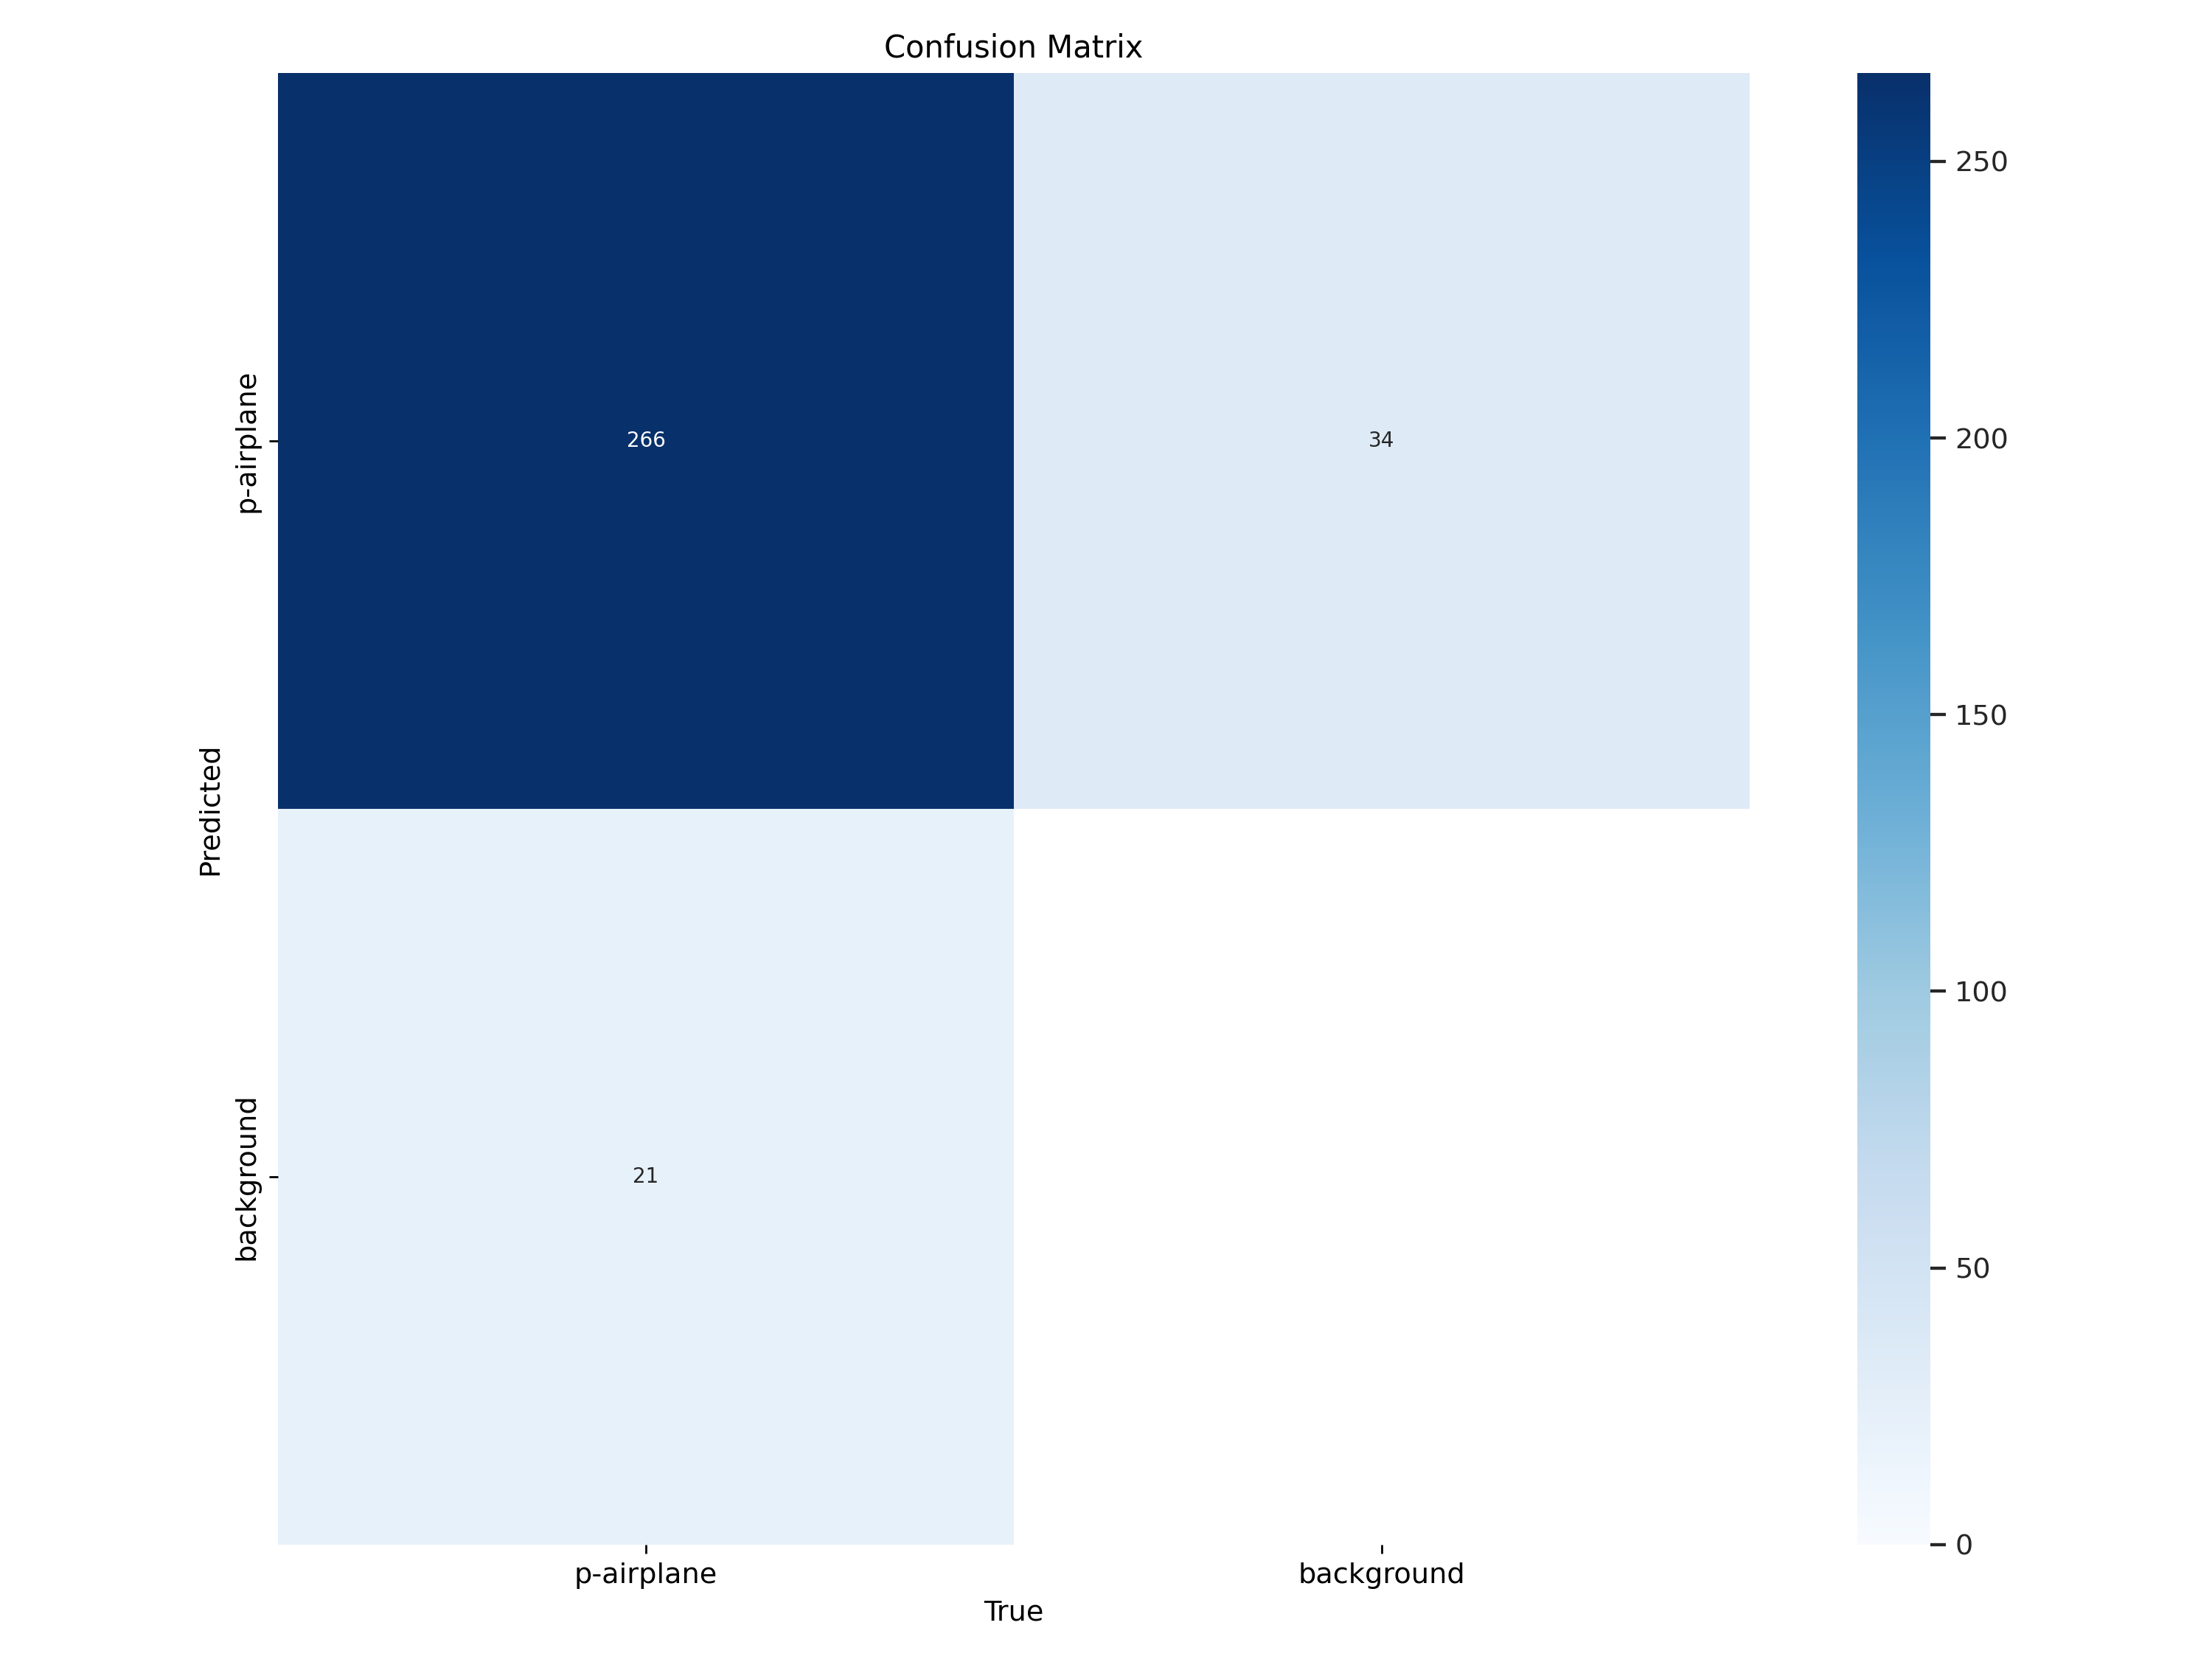

In [ ]:
display.Image(filename=f'/content/gdrive/MyDrive/OpenImages/runs/detect/train/confusion_matrix.png', width=1000)

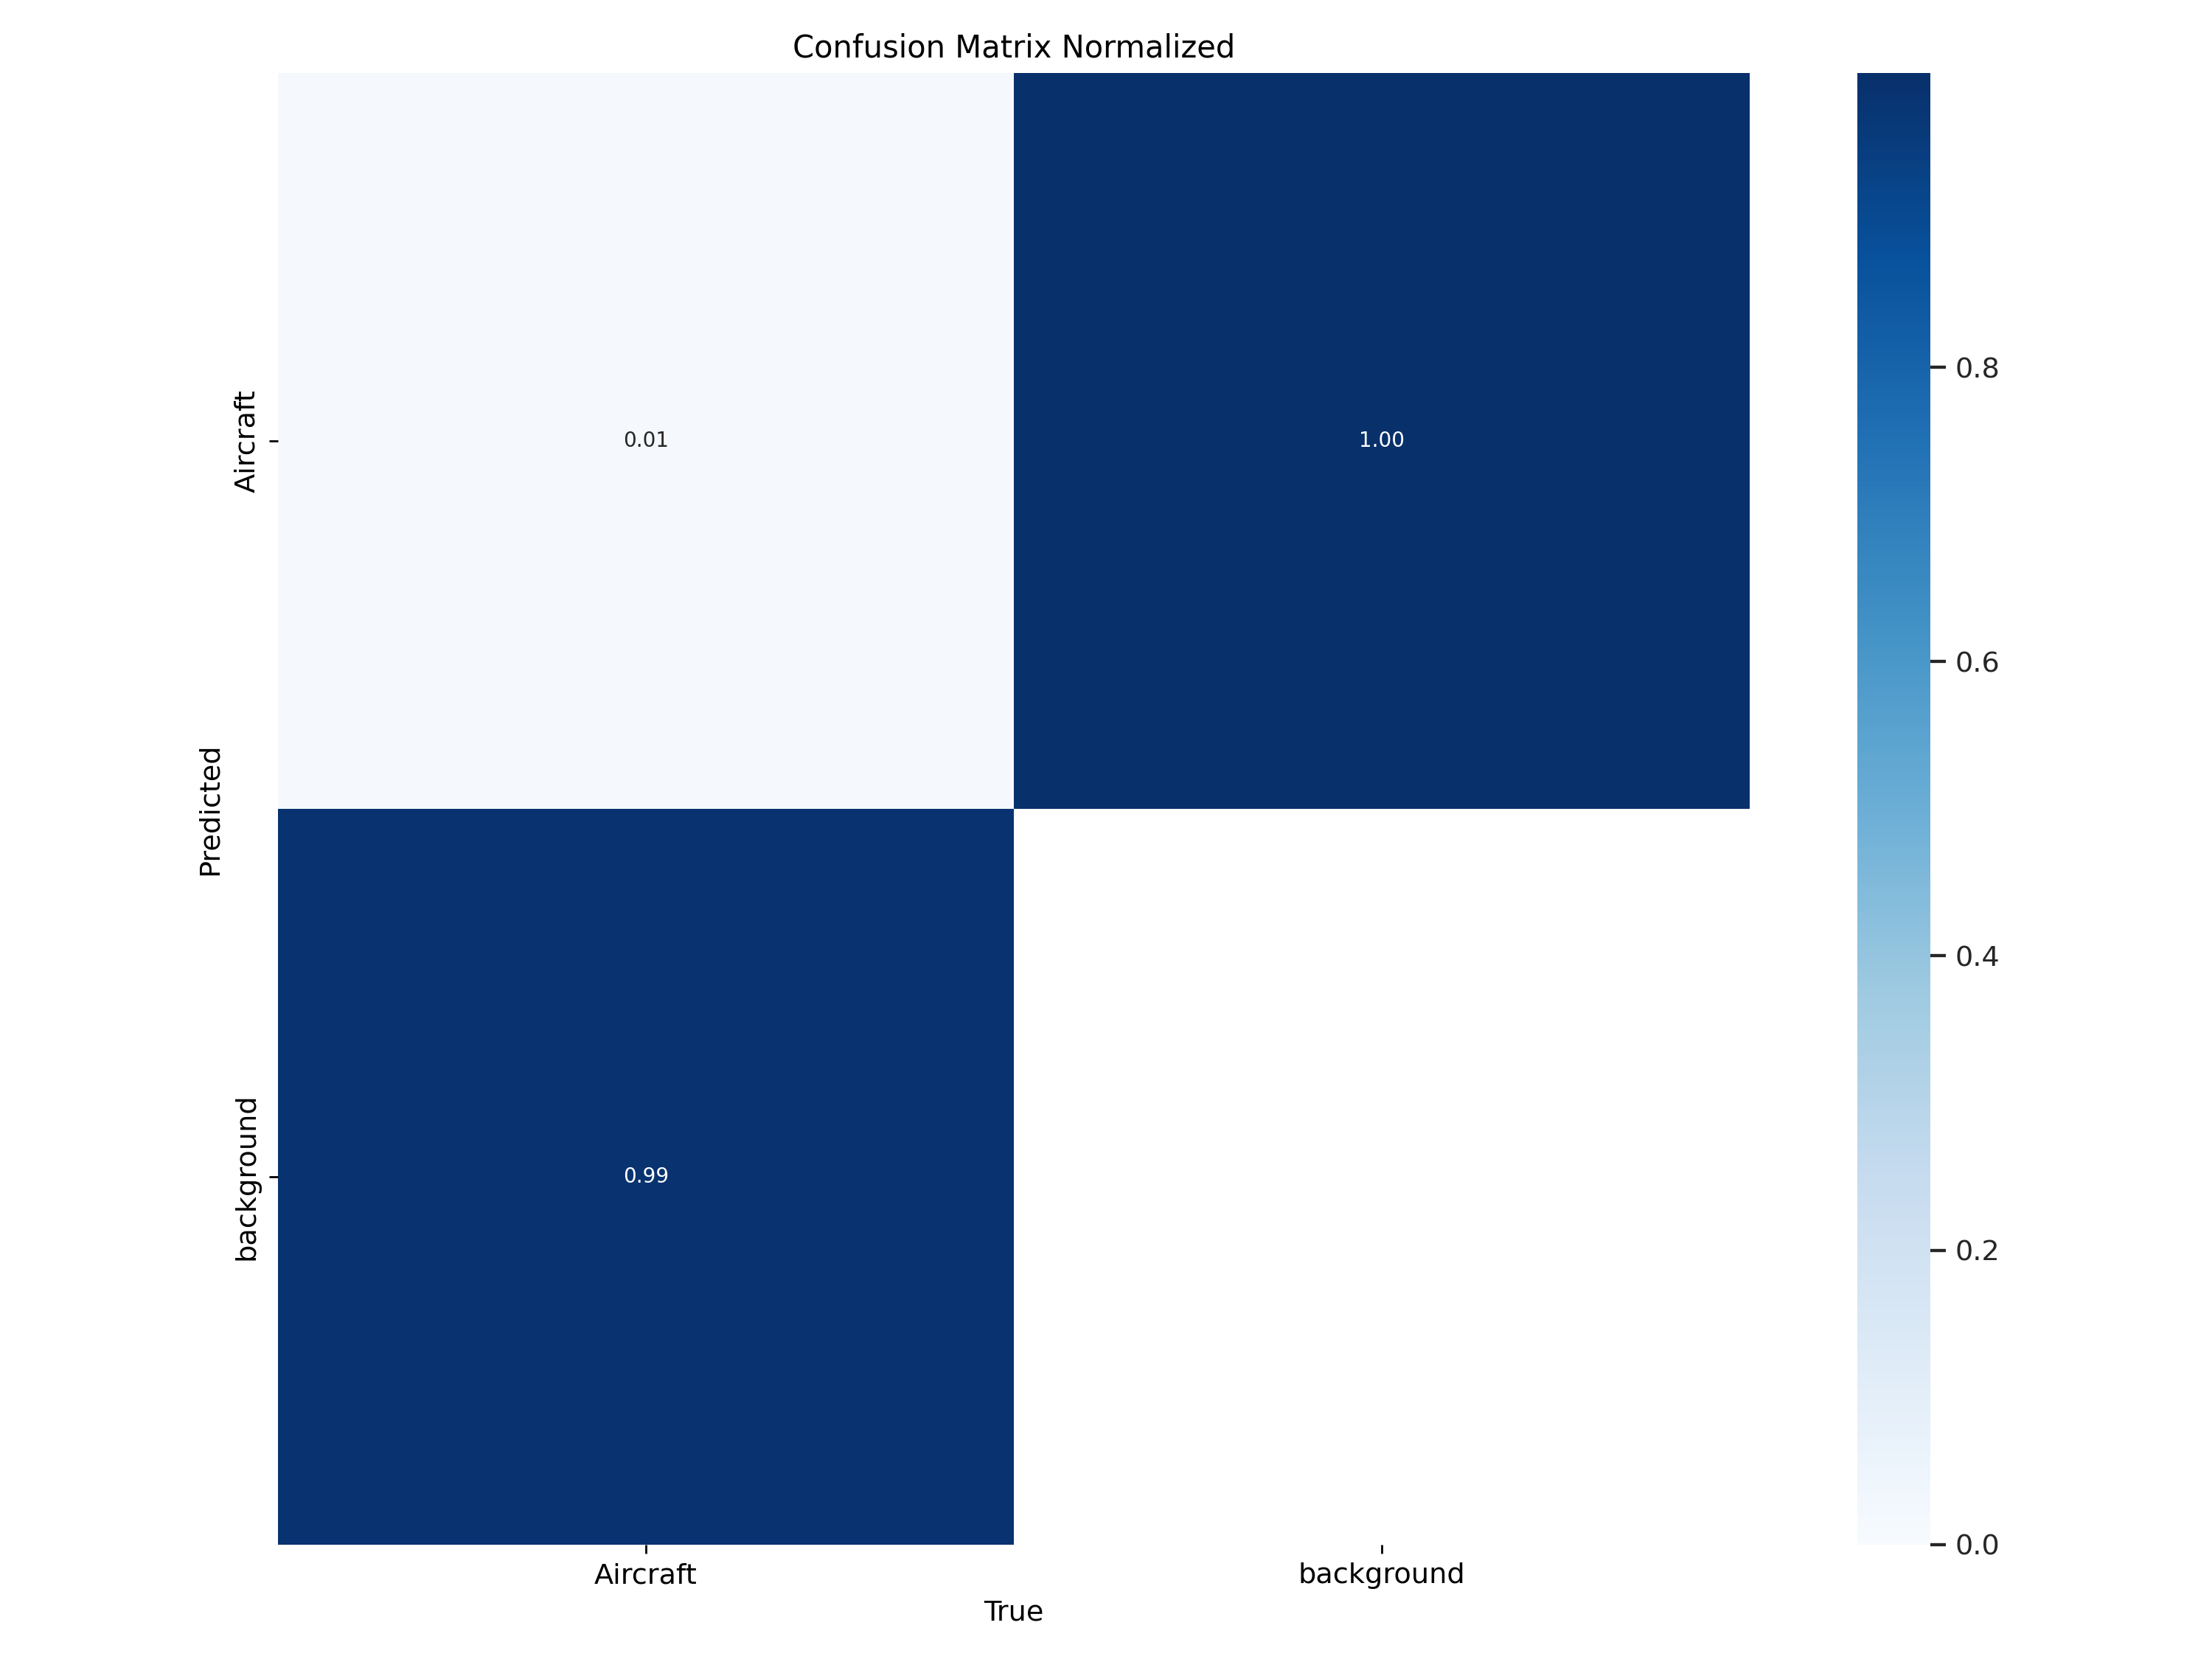

In [ ]:
display.Image(filename=f'/content/gdrive/MyDrive/OpenImages/runs/detect/val2/confusion_matrix_normalized.png', width=1000)

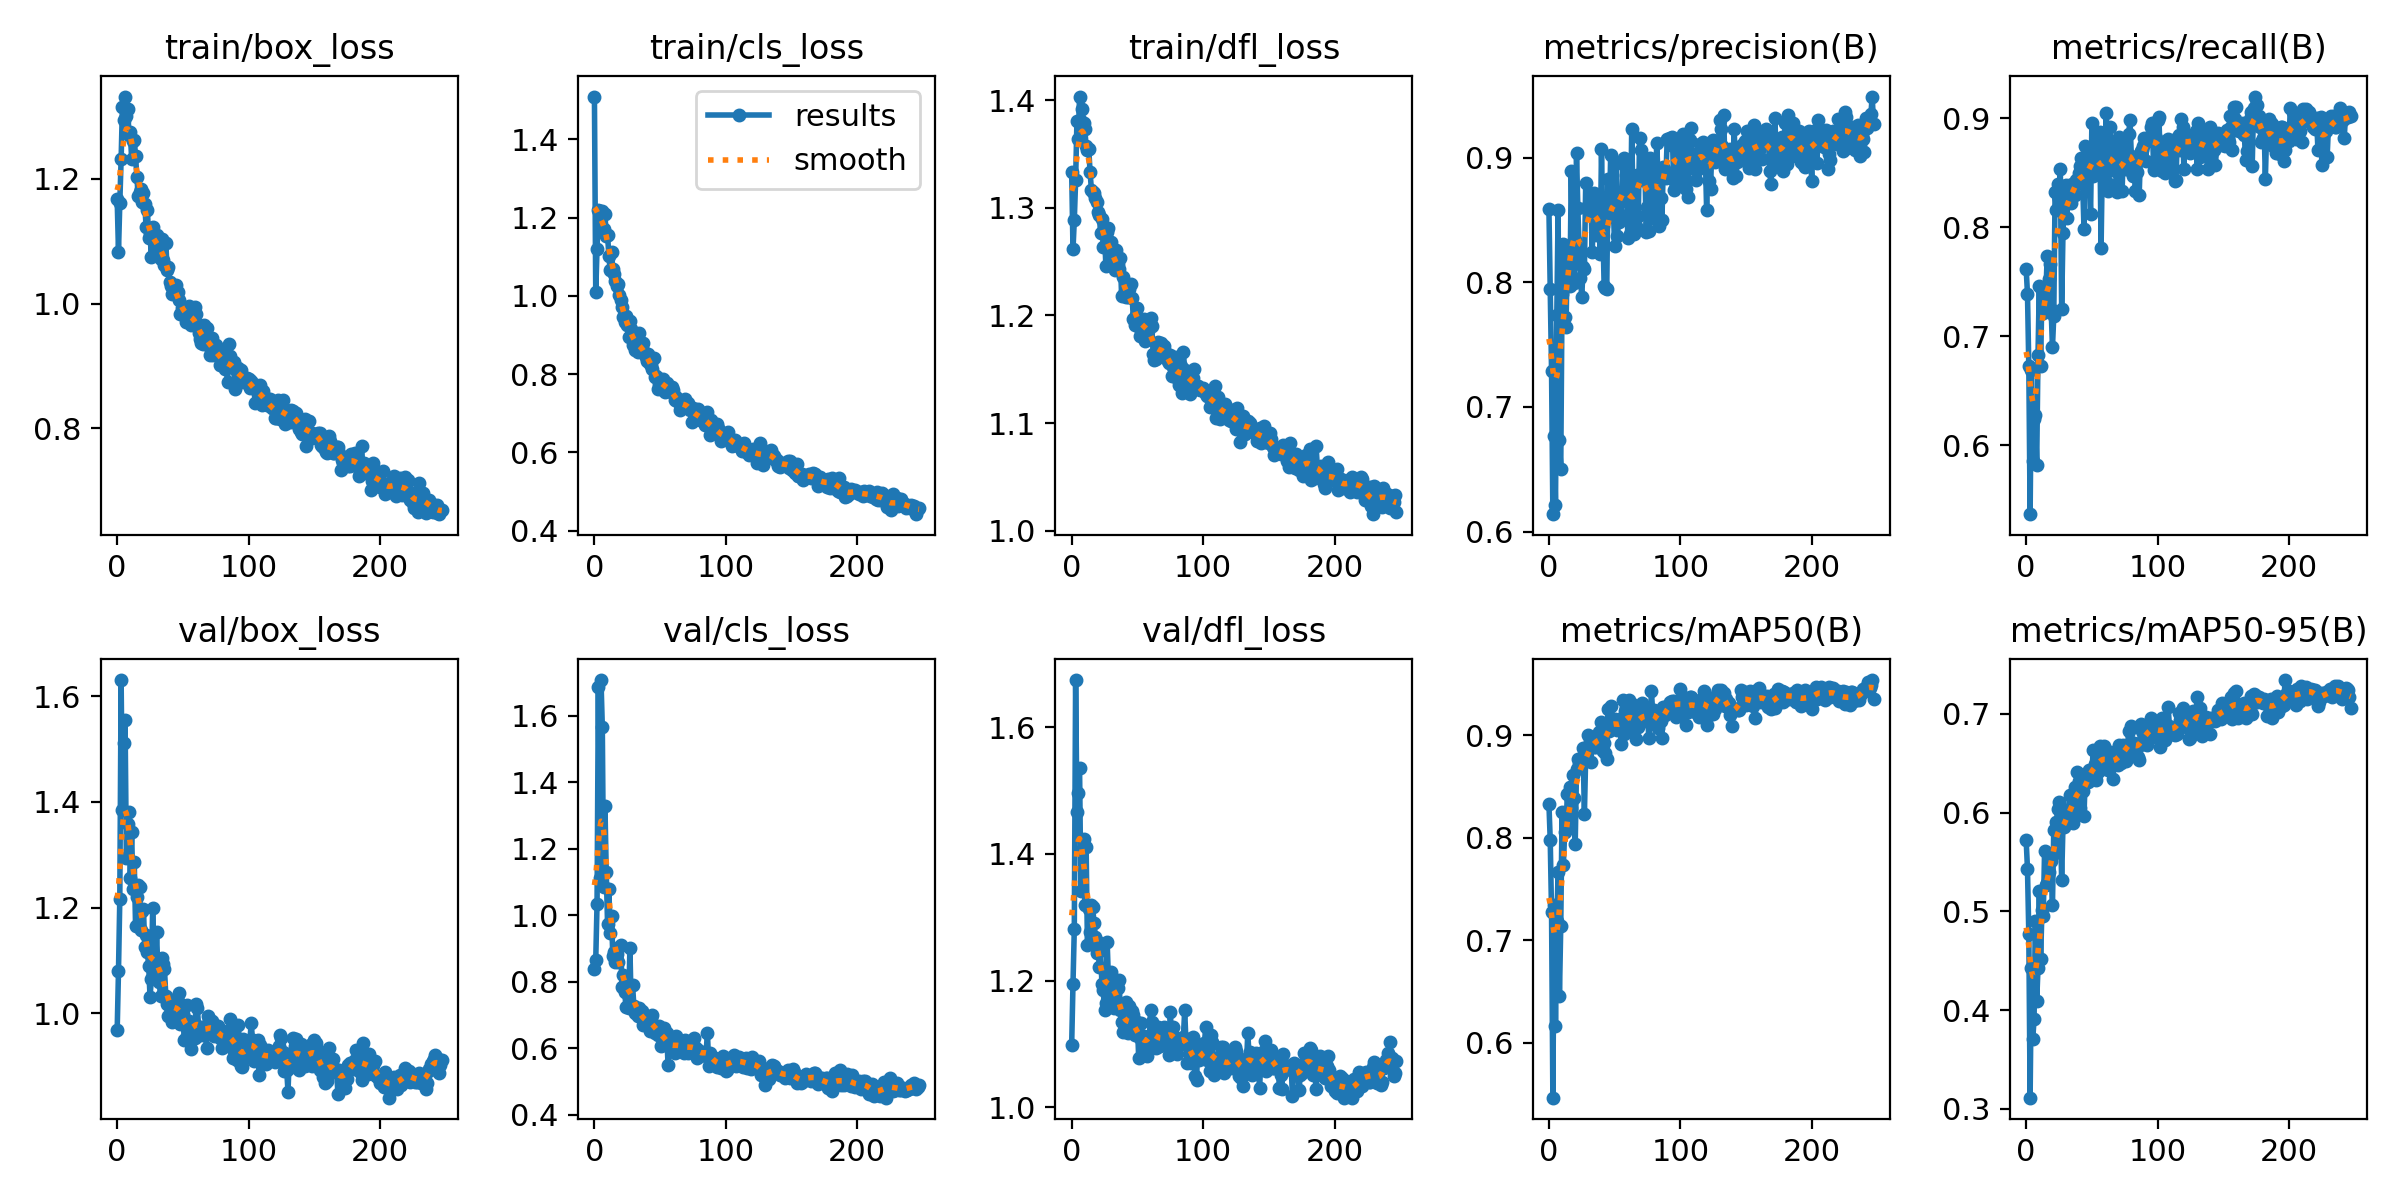

In [ ]:
display.Image(filename=f'/content/gdrive/MyDrive/OpenImages/runs/detect/train2/results.png', width=2000)

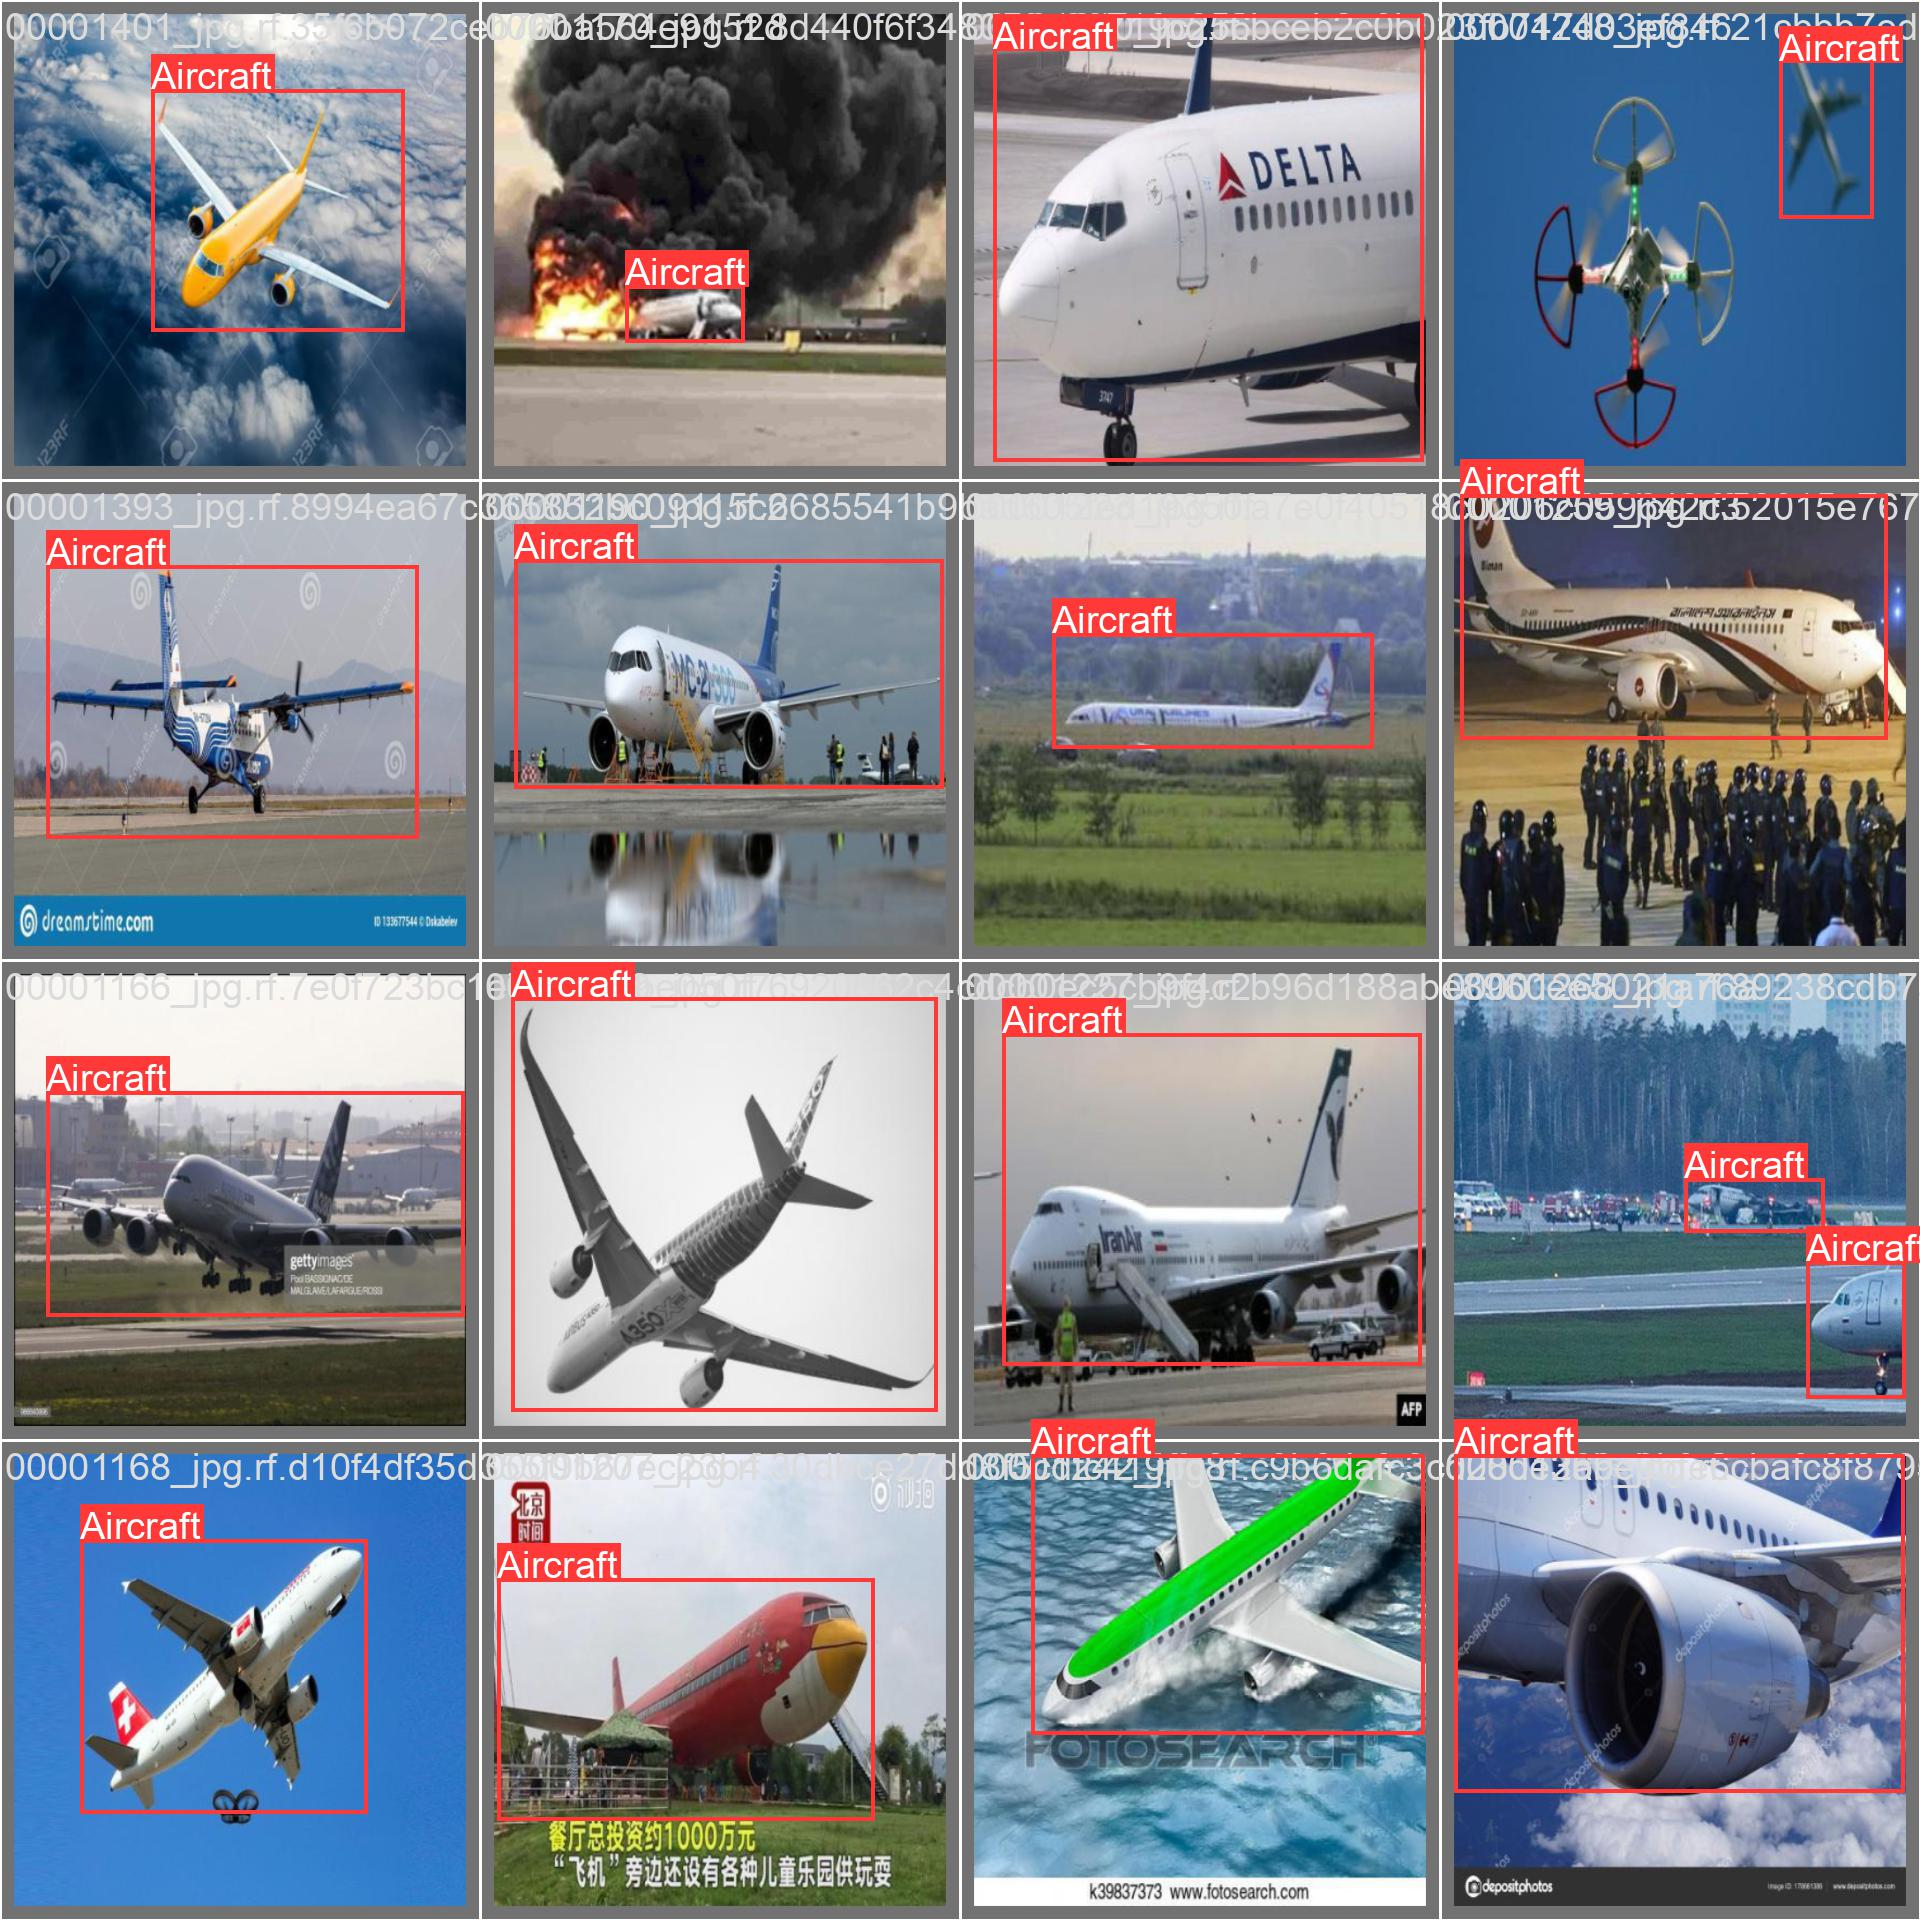

In [ ]:
display.Image(filename=f'/content/gdrive/MyDrive/OpenImages/runs/detect/val2/val_batch2_labels.jpg', width=1000)

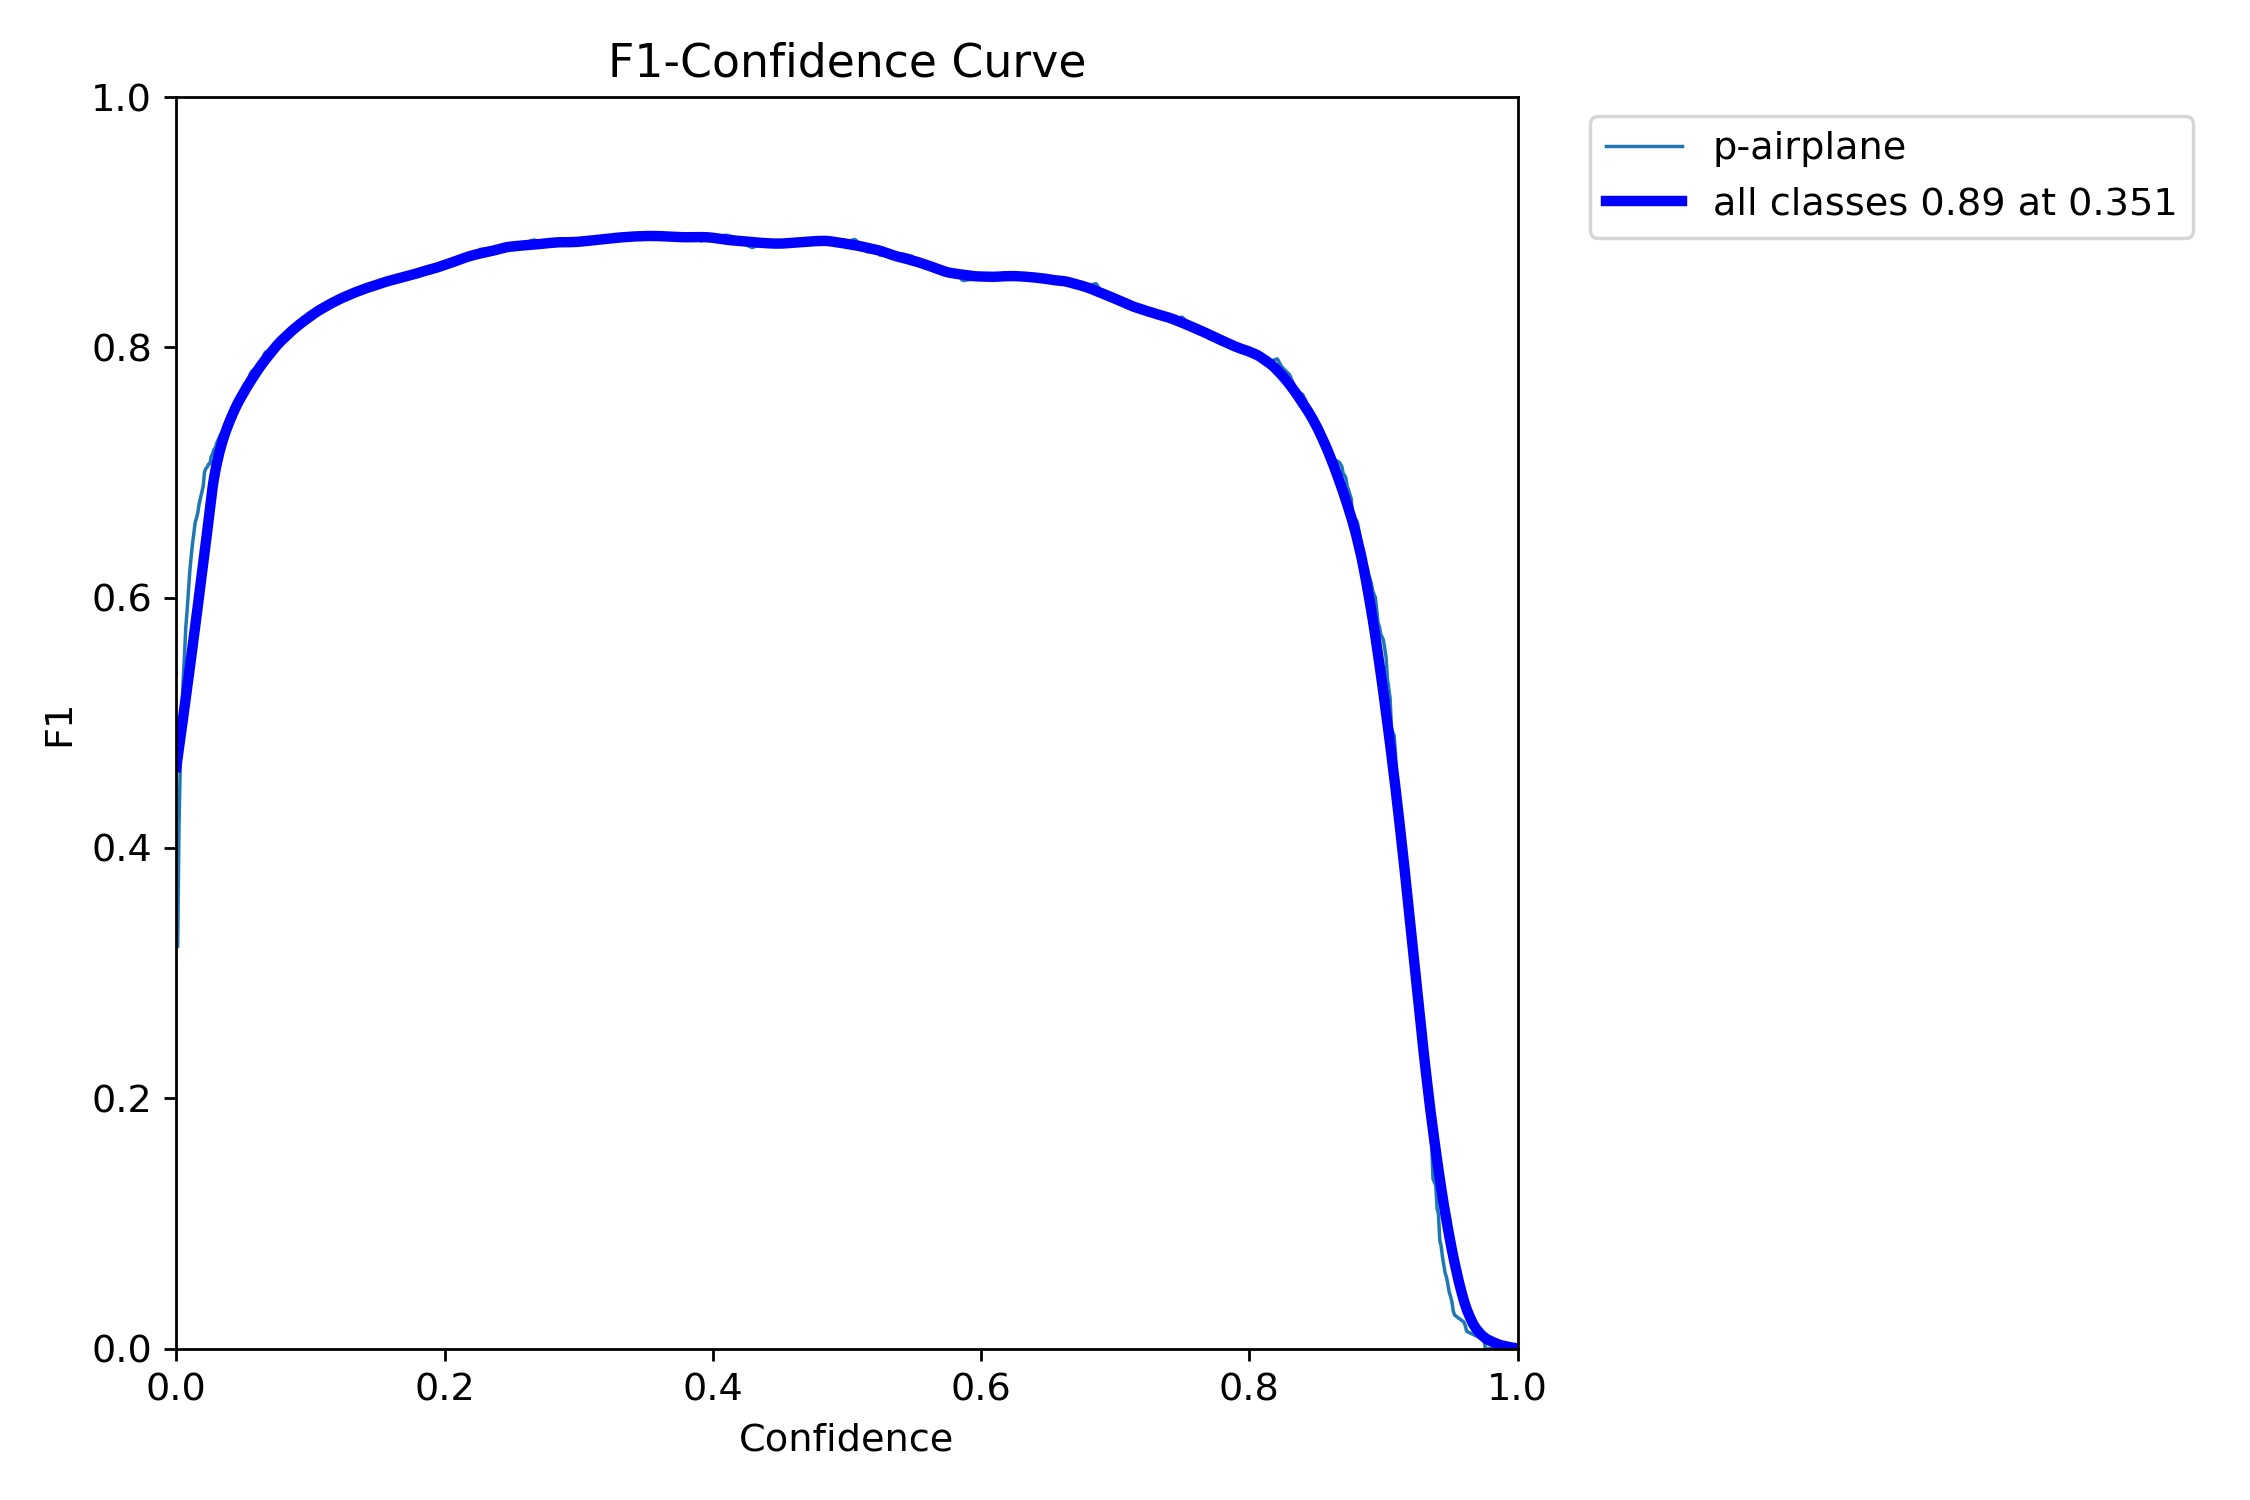

In [ ]:
display.Image(filename=f'//content/gdrive/MyDrive/OpenImages/runs/detect/train/F1_curve.png', width=1000)

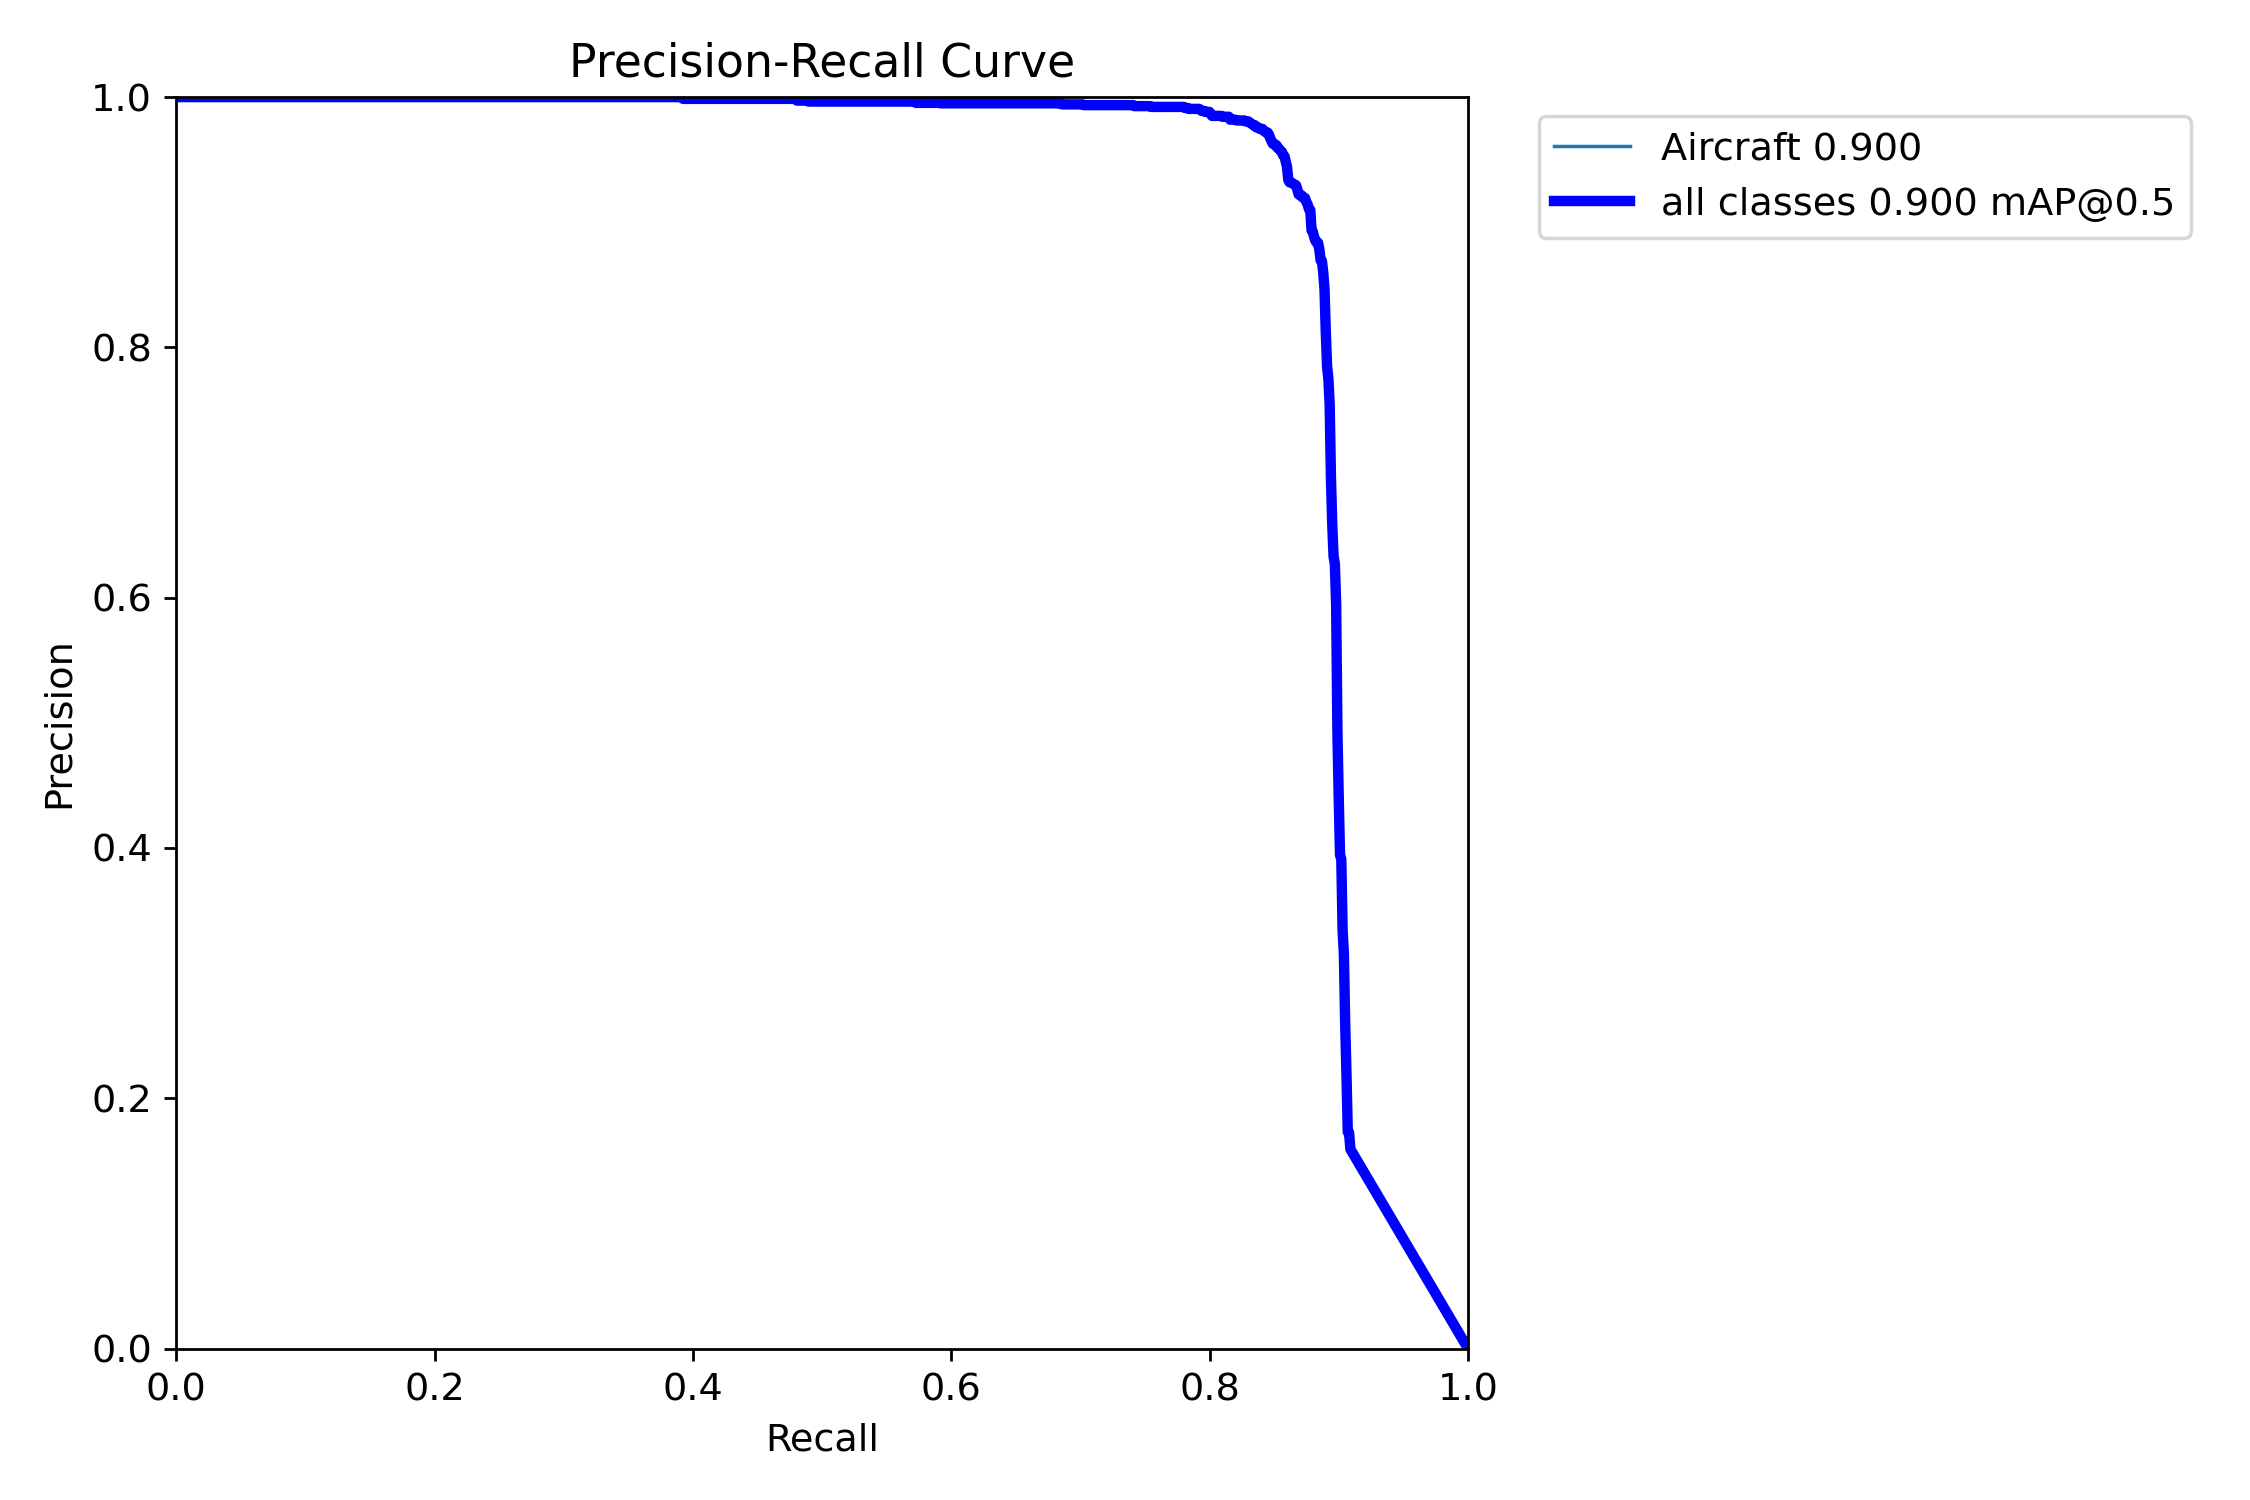

In [ ]:
display.Image(filename=f'/content/gdrive/MyDrive/OpenImages/runs/detect/val/PR_curve.png', width=1000)

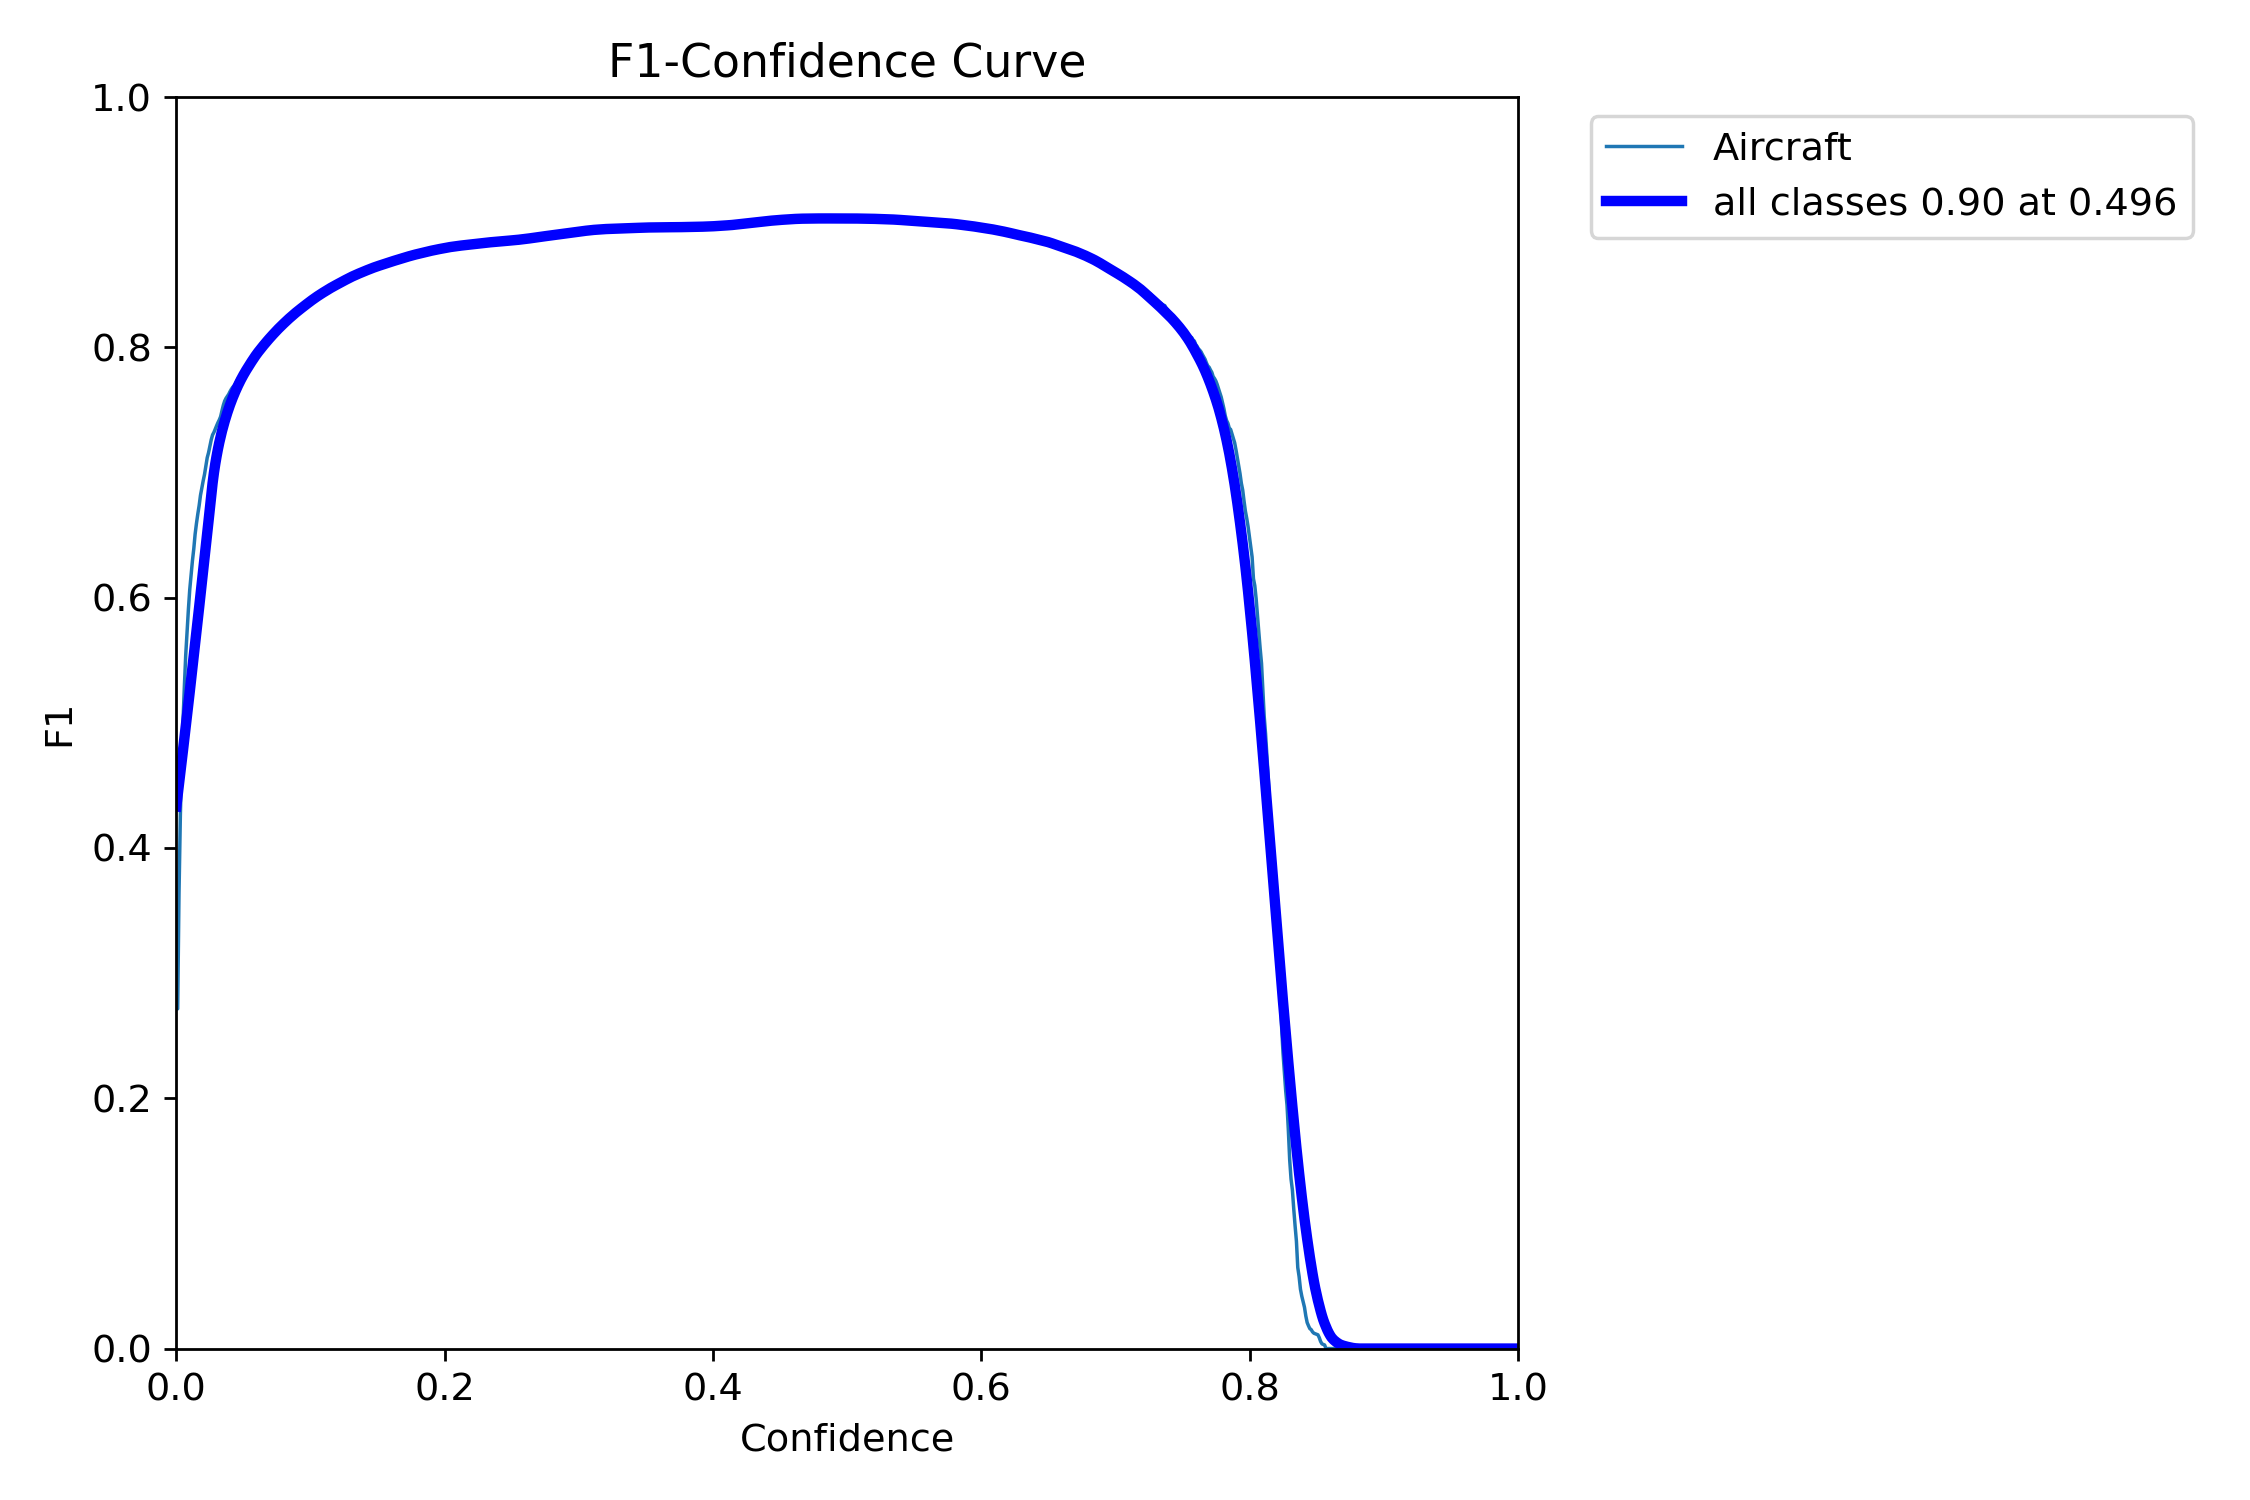

In [ ]:
display.Image(filename=f'/content/gdrive/MyDrive/OpenImages/runs/detect/val/F1_curve.png', width=1000)

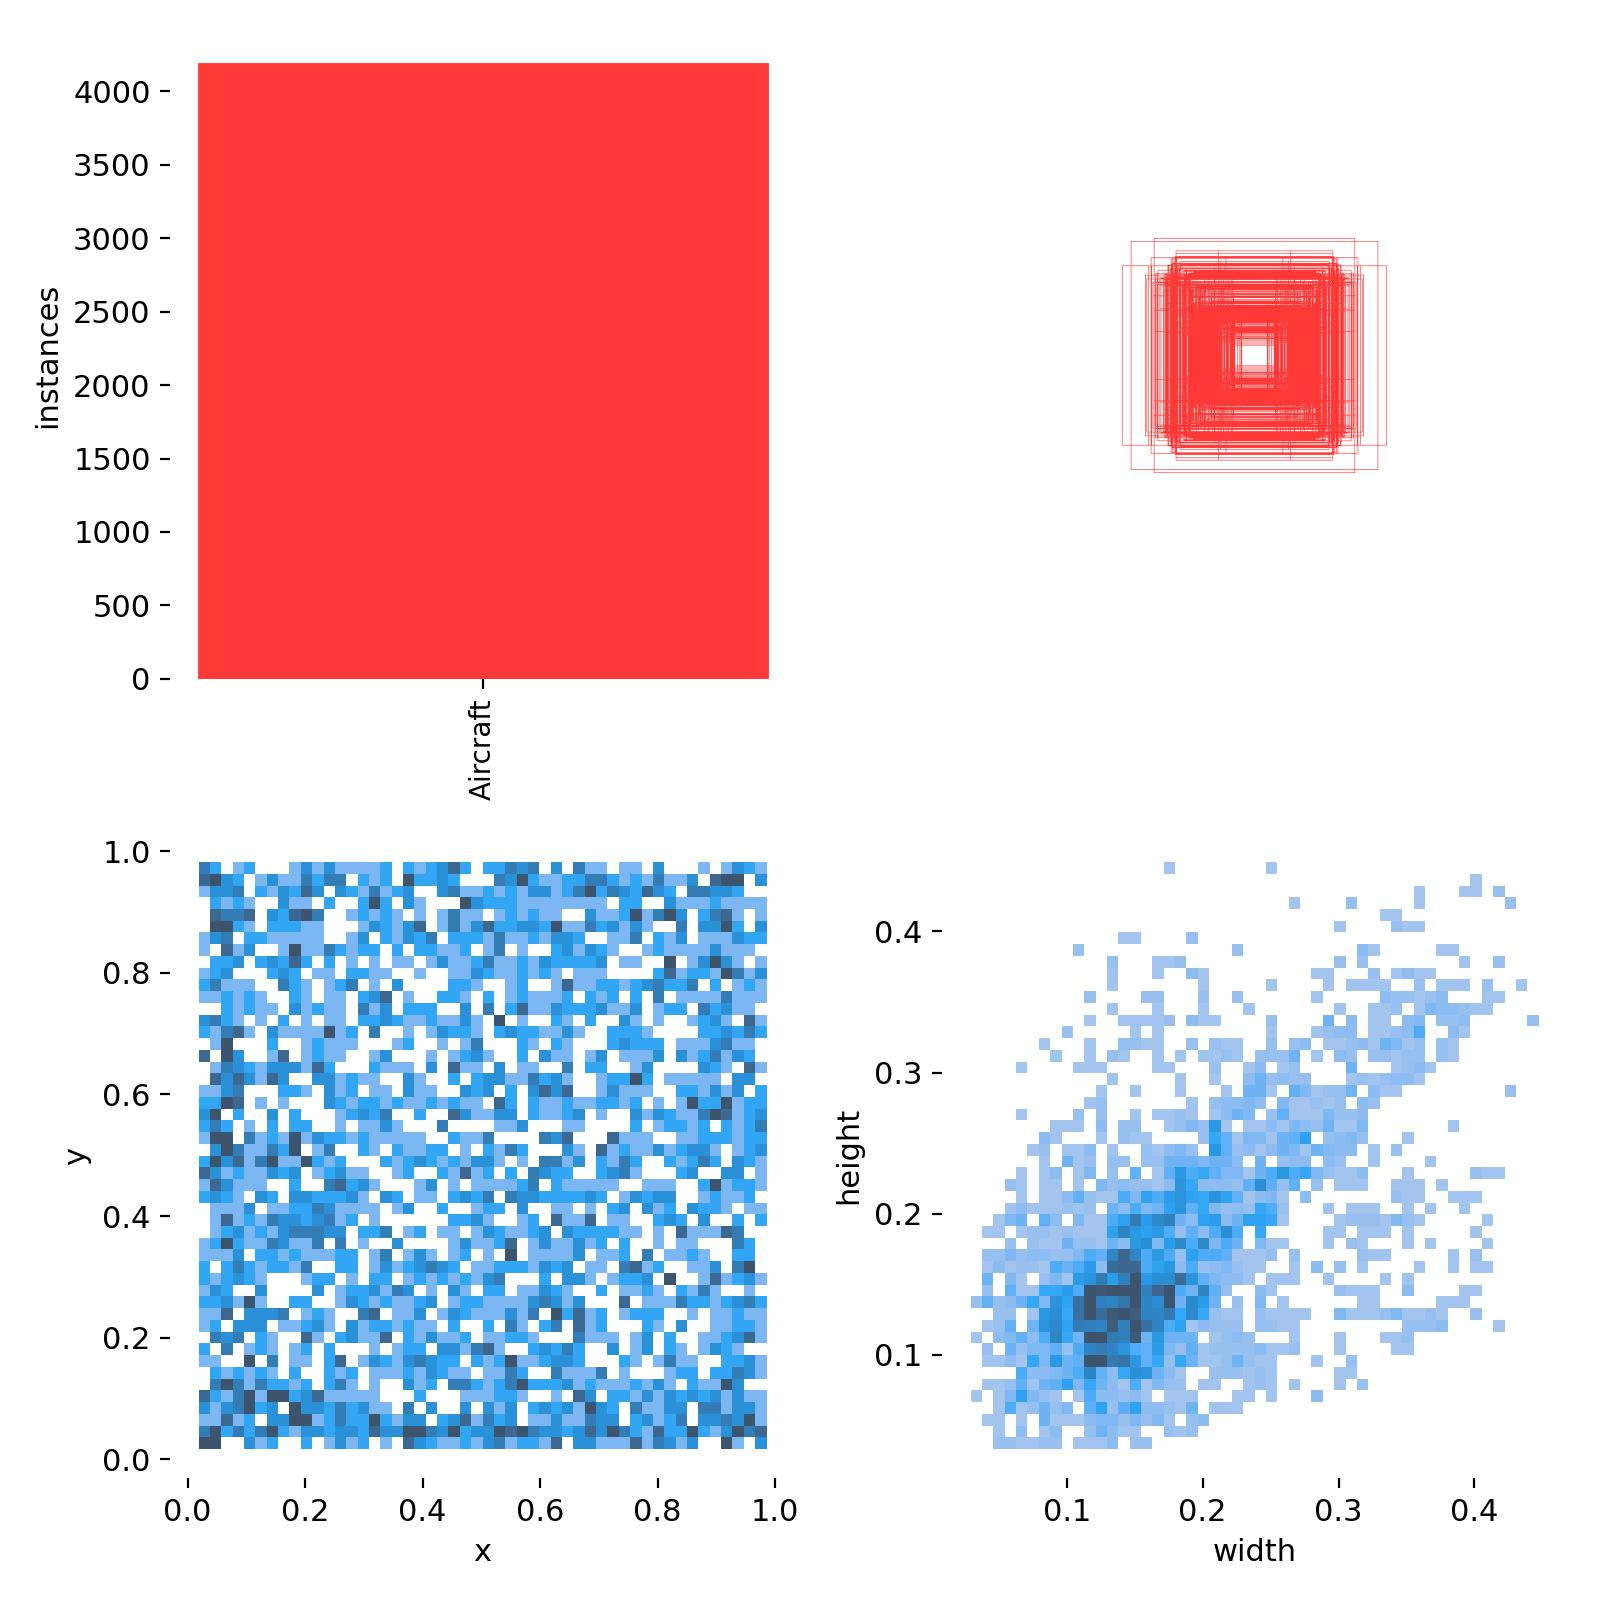

In [ ]:
display.Image(filename=f'{HOME}/runs/detect/train/labels.jpg', width=2000)

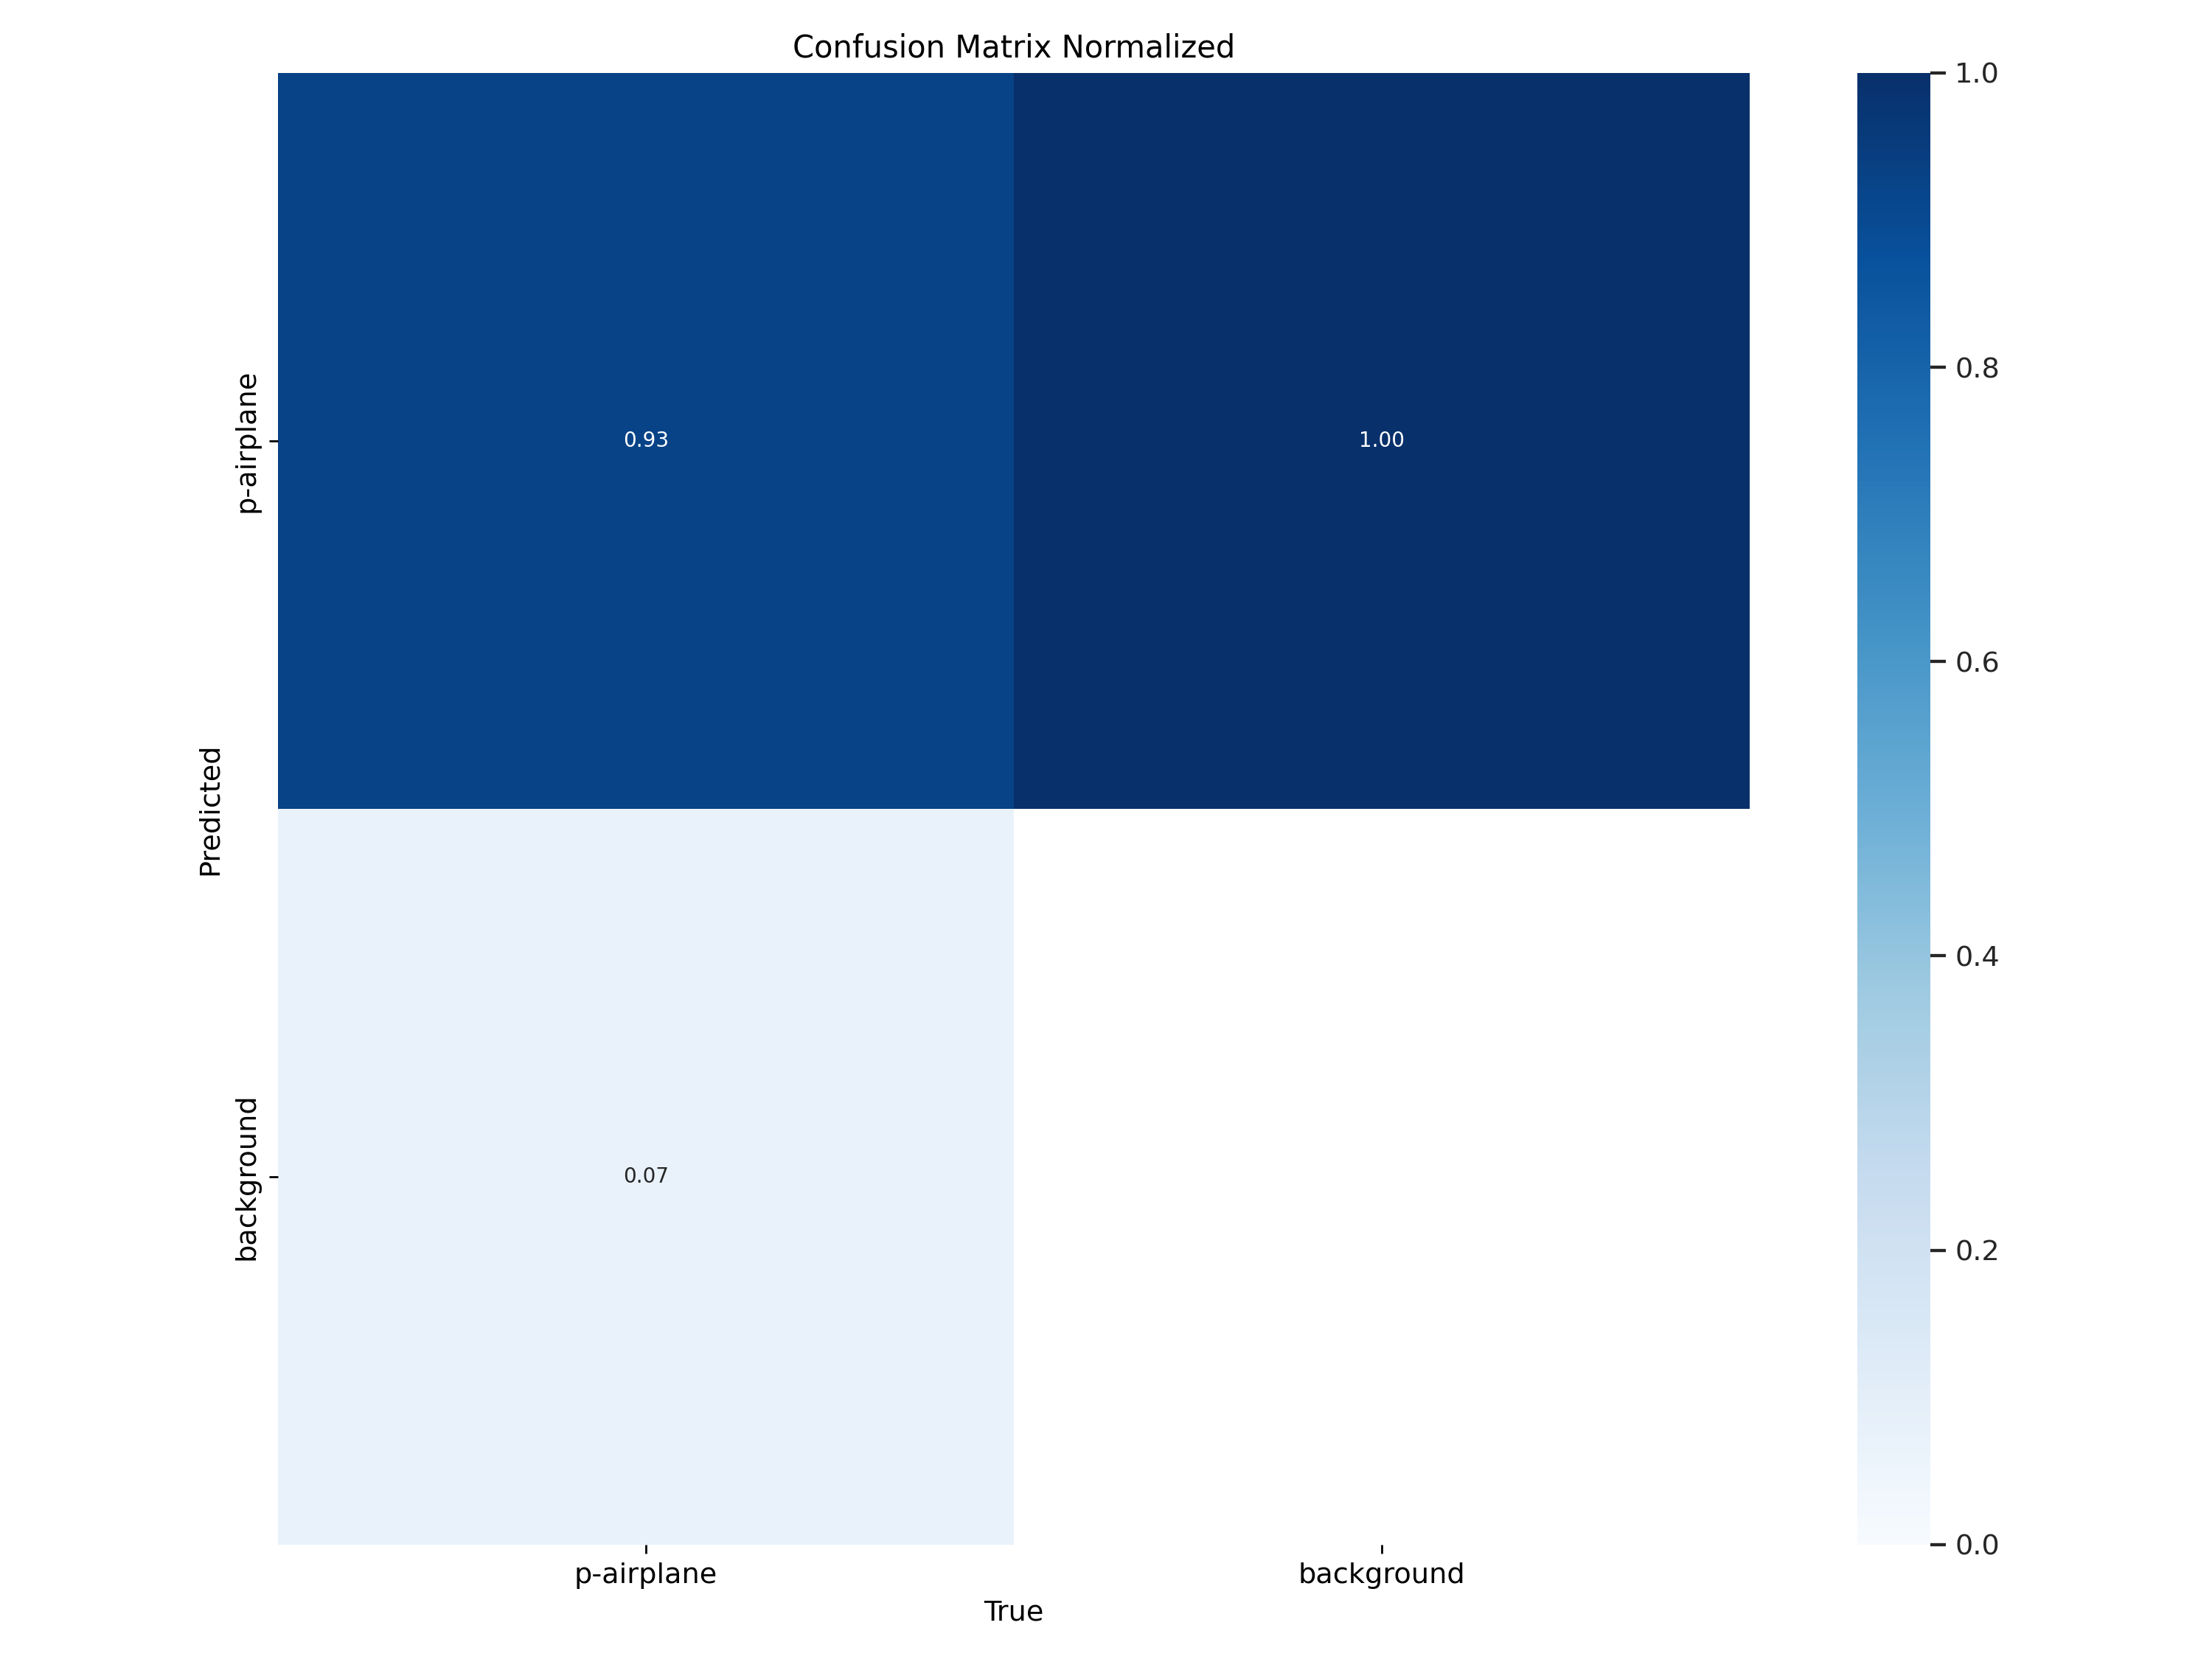

In [ ]:
display.Image(filename=f'/content/gdrive/MyDrive/OpenImages/runs/detect/train/confusion_matrix_normalized.png', width=1000)

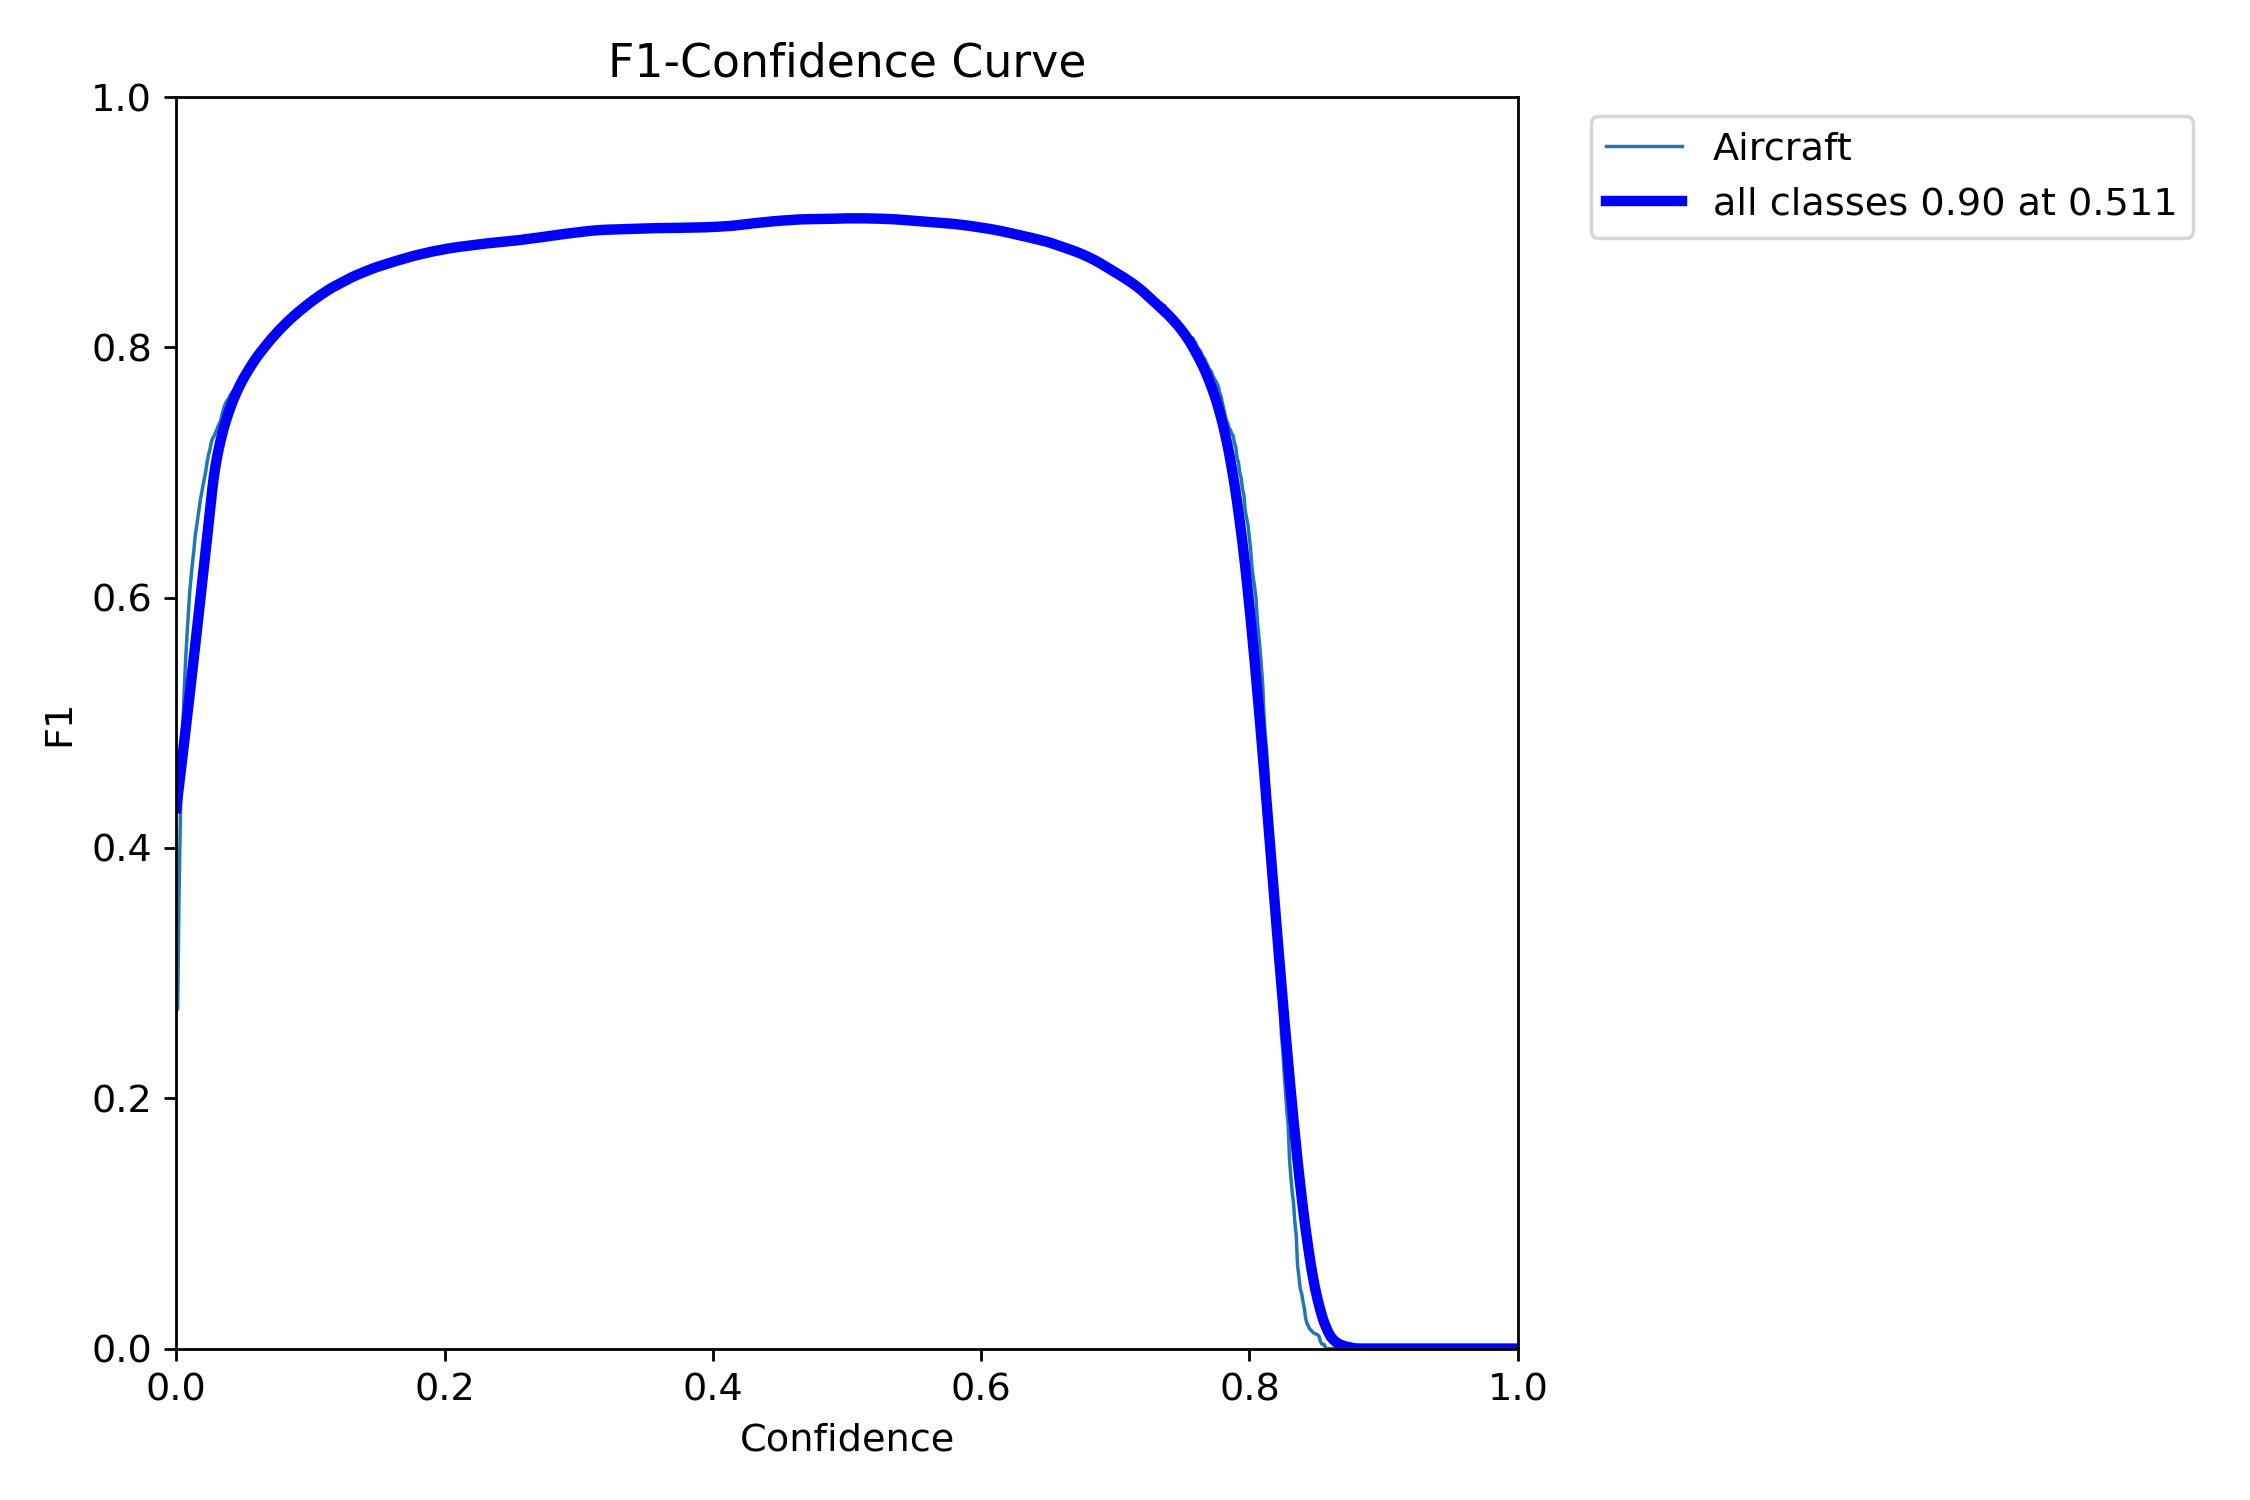

In [ ]:
display.Image(filename=f'{HOME}/runs/detect/train/F1_curve.png', width=1000)

In [ ]:
import plotly.express as px
import pandas as pd

df = pd.read_csv("/content/gdrive/MyDrive/OpenImages/runs/detect/train2/results.csv")
fig = px.line(df, x='                  epoch', y='       metrics/mAP50(B)', title='mAP50')
fig.show()

In [ ]:
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,0,1.4534,1.73740,1.3562,0.84302,0.69363,0.77024,0.44535,1.3982,0.95471,1.4458,0.000663,0.000663,0.000663
1,1,1.4289,1.00950,1.3573,0.85926,0.70299,0.78463,0.47932,1.3552,1.13060,1.4237,0.001198,0.001198,0.001198
2,2,1.3974,0.96137,1.3374,0.86249,0.74640,0.83769,0.50406,1.4183,0.81369,1.4644,0.001601,0.001601,0.001601
3,3,1.3872,0.90005,1.3230,0.90982,0.70531,0.80311,0.52447,1.2995,0.87814,1.3598,0.001406,0.001406,0.001406
4,4,1.3271,0.80104,1.2942,0.92489,0.79849,0.87079,0.57759,1.2418,0.67158,1.3378,0.001406,0.001406,0.001406
5,5,1.2949,0.78207,1.2730,0.93113,0.82473,0.88352,0.61532,1.1306,0.58912,1.2515,0.001208,0.001208,0.001208
6,6,1.2309,0.70758,1.2287,0.94548,0.84396,0.89168,0.61073,1.1269,0.56909,1.2433,0.001010,0.001010,0.001010
7,7,1.1888,0.66624,1.1985,0.94478,0.83266,0.88832,0.61468,1.1347,0.54899,1.2510,0.000812,0.000812,0.000812
8,8,1.1809,0.61761,1.1889,0.95949,0.84407,0.90180,0.64548,1.0801,0.49301,1.2161,0.000614,0.000614,0.000614
9,9,1.1096,0.57613,1.1625,0.96233,0.84990,0.89973,0.64598,1.0633,0.47691,1.2027,0.000416,0.000416,0.000416


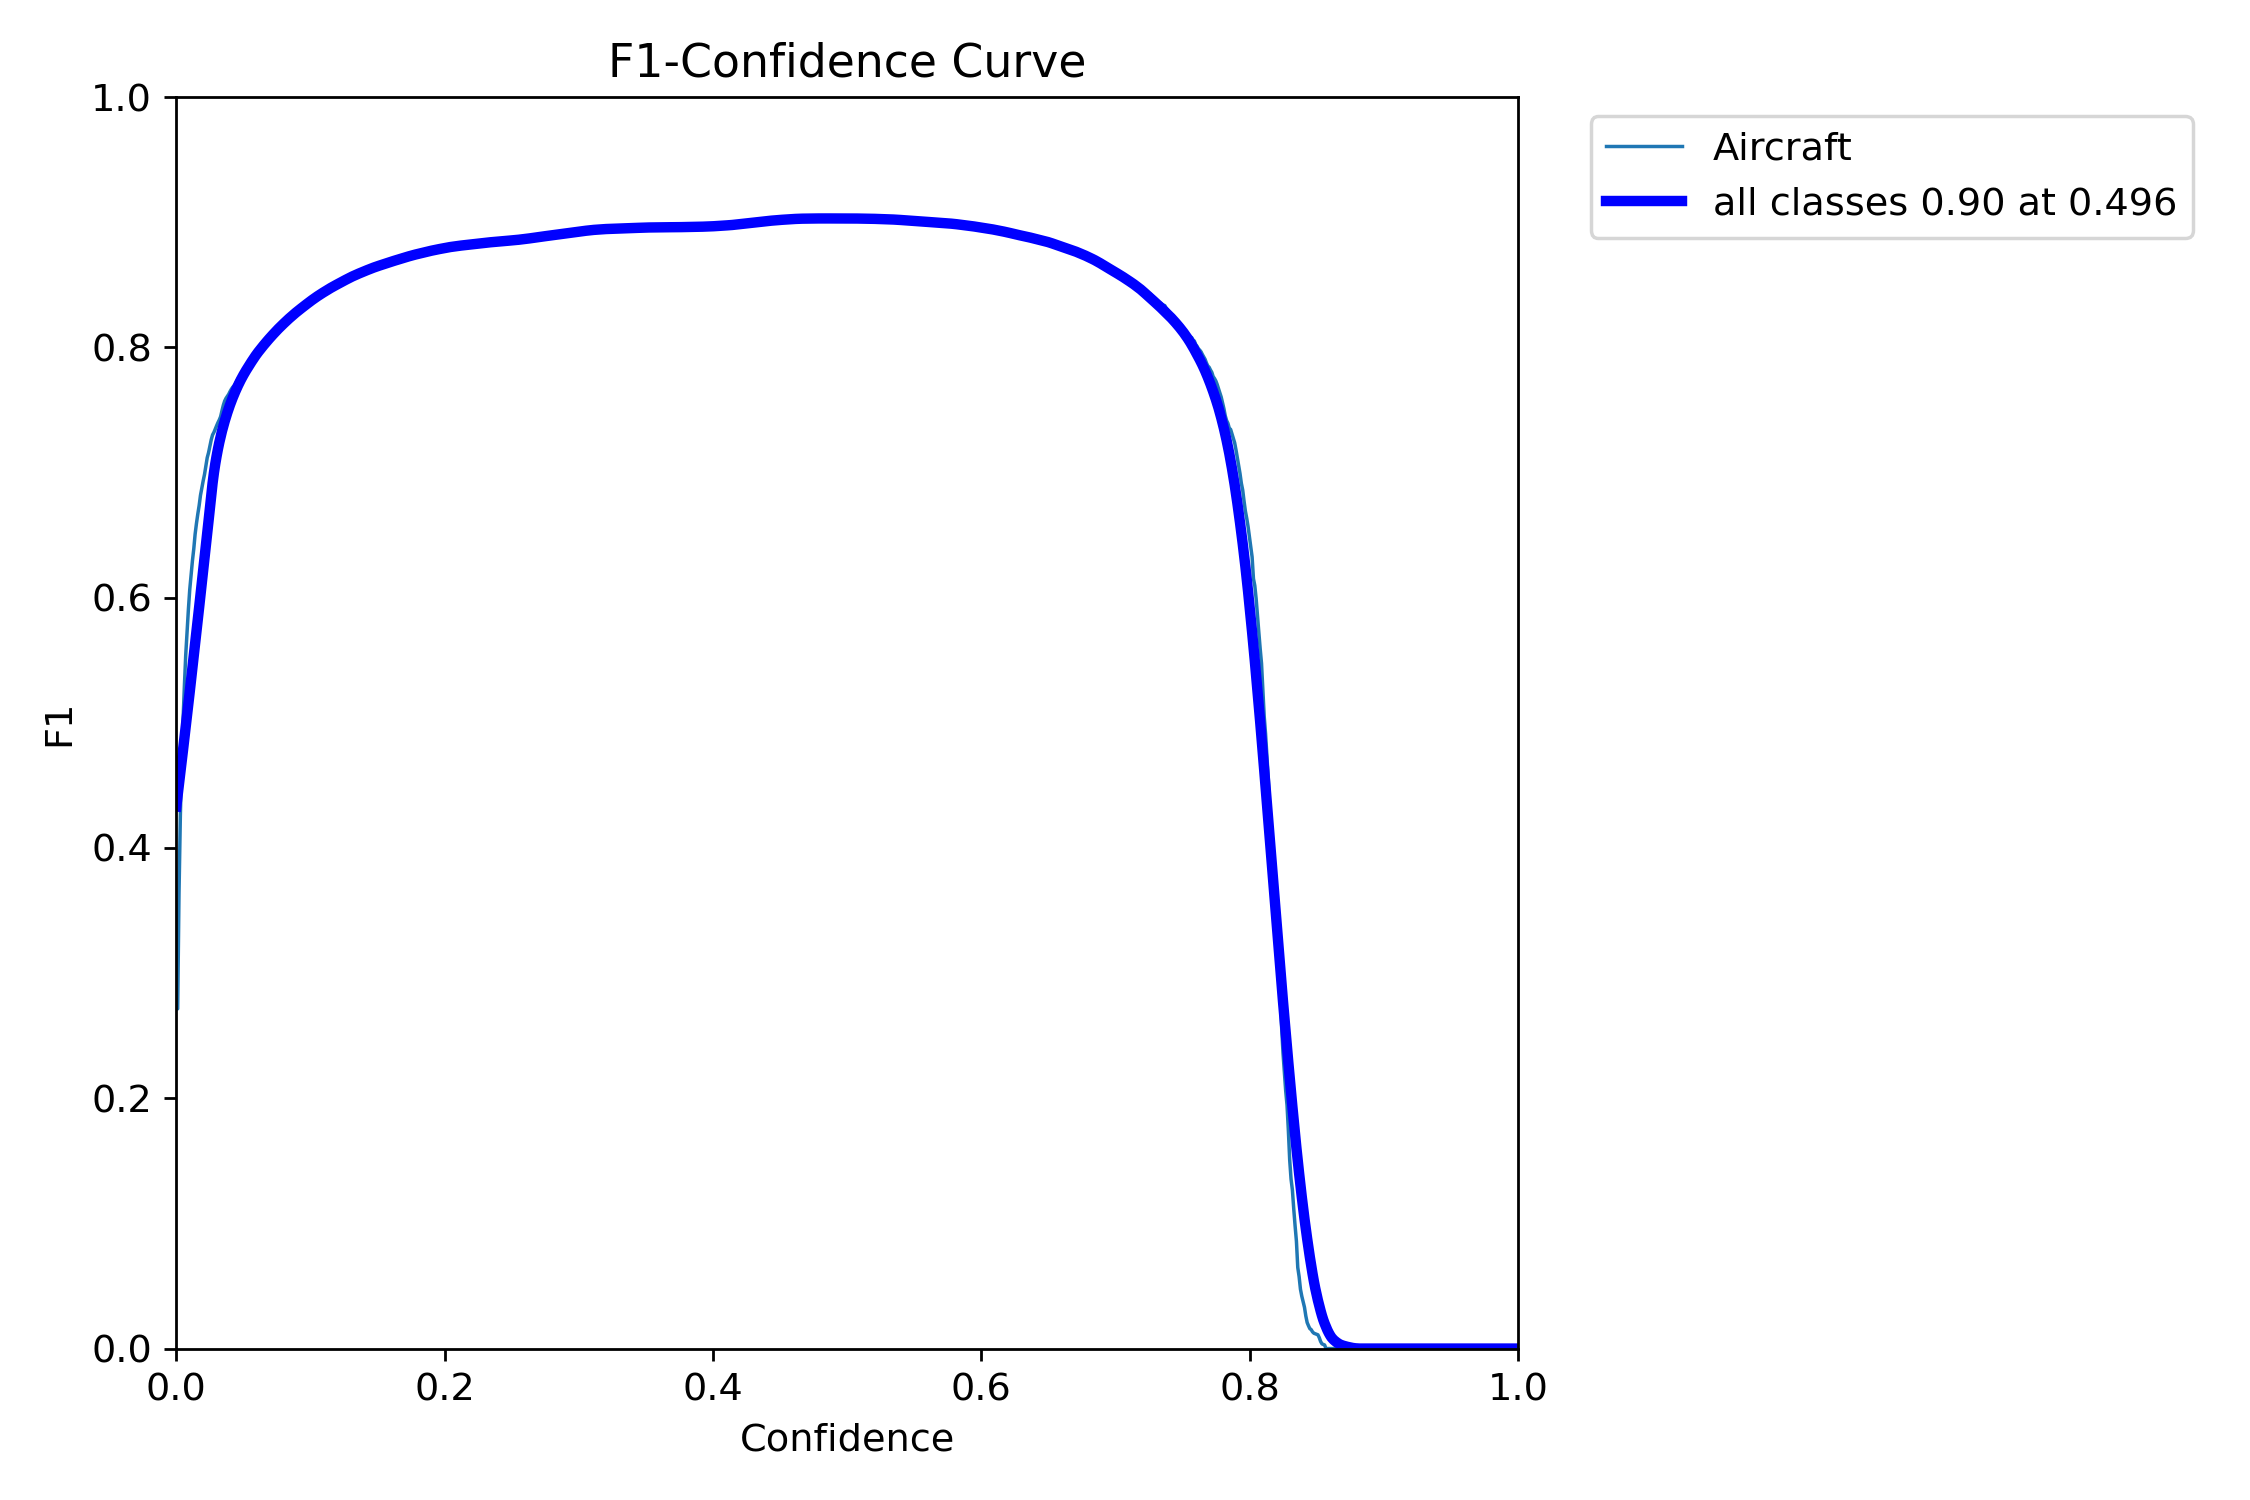

In [ ]:
display.Image(filename=f'/content/gdrive/MyDrive/OpenImages/runs/detect/val/F1_curve.png', width=1000)

In [ ]:
display.Image(filename=f'{HOME}/runs/detect/val2/P_curve.png', width=1000)

In [ ]:
display.Image(filename=f'{HOME}/runs/detect/val2/R_curve.png', width=1000)

In [ ]:

!yolo task=detect mode=val model=/content/gdrive/MyDrive/OpenImages/runs/detect/train/weights/best.pt data=/content/gdrive/MyDrive/OpenImages/final-airplane--1/data.yaml

Ultralytics YOLOv8.0.136 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients
100% 755k/755k [00:00<00:00, 16.1MB/s]
val: Scanning /content/gdrive/MyDrive/OpenImages/final-airplane--1/valid/labels.cache... 269 images, 0 backgrounds, 0 corrupt: 100% 269/269 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 17/17 [00:06<00:00,  2.79it/s]
                   all        269        287      0.897      0.883      0.938      0.733
Speed: 0.8ms preprocess, 5.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val3


#Prediction

In [ ]:
!yolo task=detect mode=predict model=/content/gdrive/MyDrive/OpenImages/runs/detect/train/weights/best.pt source='/content/gdrive/MyDrive/OpenImages/input/airplane.jpg' show=True


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Ultralytics YOLOv8.0.132 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients

image 1/1 /content/gdrive/MyDrive/OpenImages/input/airplane.jpg: 288x416 1 p-airplane, 104.7ms
Speed: 2.3ms preprocess, 104.7ms inference, 2.4ms postprocess per image at shape (1, 3, 288, 416)
Results saved to runs/detect/predict2


#Show only a predicted bild

In [ ]:
import subprocess
import matplotlib.pyplot as plt
from PIL import Image
import re

# Define the command to execute
command = "yolo task=detect mode=predict model=/content/gdrive/MyDrive/MasterProject/runs/detect/train/weights/yolov8n.pt source='/content/gdrive/MyDrive/MasterProject/input/'"

# Execute the command and capture the output
output = subprocess.getoutput(command)

# Specify the base directory
base_directory = "/content/gdrive/MyDrive/MasterProject/runs/detect"

# Find the latest "predict" directory
predict_directory = None
predict_number = -1

for folder_name in os.listdir(base_directory):
    if folder_name.startswith("predict"):
        match = re.search(r"\d+$", folder_name)
        if match:
            current_number = int(match.group())
            if current_number > predict_number:
                predict_number = current_number
                predict_directory = folder_name

# Check if a "predict" directory was found
if predict_directory:
    # Construct the path to the resulting image
    result_image_path = os.path.join(base_directory, predict_directory, "airplane.jpg")
    result_image_path1 = os.path.join(base_directory, predict_directory, "emirates-airplane.jpg")
    # Check if the resulting image exists
    if os.path.isfile(result_image_path):
        # Load and display the resulting image
        result_image = Image.open(result_image_path)
        plt.imshow(result_image)
        plt.axis('off')
        plt.show()

     # Check if the resulting image exists
    if os.path.isfile(result_image_path1):
        # Load and display the resulting image
        result_image = Image.open(result_image_path1)
        plt.imshow(result_image)
        plt.axis('off')
        plt.show()
    else:
        print("Resulting image not found.")
else:
    print("No 'predict' directory found.")


No 'predict' directory found.


#Show only the predicted video

In [ ]:
import subprocess
import matplotlib.pyplot as plt
from PIL import Image
import re
from IPython.display import HTML
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
import imageio.core.util

def display_video(video):
    # Display size specification
    fig = plt.figure(figsize=(10, 10))

    mov = []
    # Append video one by one to mov
    for i in range(len(video)):
        img = plt.imshow(video[i], animated=True)
        plt.axis('off')
        mov.append([img])

    # Animation creation
    anime = animation.ArtistAnimation(fig, mov, interval=50, repeat_delay=1000)
    plt.close()
    return anime

def play_predicted_video(video):
    display(HTML(display_video(video).to_html5_video()))

# Define the command to execute
command = "yolo task=detect mode=predict model=/content/gdrive/MyDrive/OpenImages/runs/detect/train/weights/best.pt source='/content/gdrive/MyDrive/MasterProject/input/airplane.mp4'"

# Execute the command and capture the output
output = subprocess.getoutput(command)

# Specify the base directory
base_directory = "/content/gdrive/MyDrive/MasterProject/runs/detect"

# Find the latest "predict" directory
predict_directory = None
predict_number = -1

for folder_name in os.listdir(base_directory):
    match = re.match(r"predict(\d+)", folder_name)
    if match:
        current_number = int(match.group(1))
        if current_number > predict_number:
            predict_number = current_number
            predict_directory = folder_name

# Check if a "predict" directory was found
if predict_directory:
    imageio.core.util._max_read_total_bytes = 500000000  # Increase threshold to 500,000,000 bytes
    video_path = os.path.join(base_directory, predict_directory, "airplane.avi")
    video_reader = imageio.get_reader(video_path)
    video = [resize(frame, (800, 800)) for frame in video_reader]
    play_predicted_video(video)
else:
    print("No 'predict' directory found.")


#Prediction of user's bild or video

In [ ]:
import os
import re
import subprocess
from google.colab import files
from IPython.display import HTML, display as ipy_display

import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize

# Function to display the video
def display_video(video):
    # Display size specification
    fig = plt.figure(figsize=(10, 10))

    mov = []
    # Append video one by one to mov
    for i in range(len(video)):
        img = plt.imshow(video[i], animated=True)
        plt.axis('off')
        mov.append([img])

    # Animation creation
    anime = animation.ArtistAnimation(fig, mov, interval=50, repeat_delay=1000)
    plt.close()
    return anime

# Function to play the predicted video
def play_predicted_video(video_path):
    video_reader = imageio.get_reader(video_path)
    video = [resize(frame, (800, 800)) for frame in video_reader]
    ipy_display(HTML(display_video(video).to_html5_video()))

# Function to handle file upload
def handle_upload(upload):
    # Save the uploaded file locally with a default name
    file_path = "/content/gdrive/MyDrive/MasterProject/input.mp4"  # Modify the path and filename as needed
    with open(file_path, 'wb') as f:
        f.write(upload)

    # Call the prediction function with the file path
    predict(file_path)

# Function for prediction
def predict(file_path):
    # Define the command to execute
    command = f"yolo task=detect mode=predict model=/content/gdrive/MyDrive/OpenImages/runs/detect/train2/weights/best.pt source='{file_path}'"

    # Execute the command and capture the output
    output = subprocess.getoutput(command)

    # Specify the base directory
    base_directory = "/content/gdrive/MyDrive/OpenImages/runs/detect"

    # Find the latest "predict" directory
    predict_directory = None
    predict_number = -1

    for folder_name in os.listdir(base_directory):
        match = re.match(r"predict(\d+)", folder_name)
        if match:
            current_number = int(match.group(1))
            if current_number > predict_number:
                predict_number = current_number
                predict_directory = folder_name

    # Check if a "predict" directory was found
    if predict_directory:
        video_path = os.path.join(base_directory, predict_directory, "input.avi")
        if os.path.isfile(video_path):
            play_predicted_video(video_path)
        else:
            print("Predicted video not found.")
    else:
        print("No 'predict' directory found.")

# Ask the user to upload a file
uploaded_files = files.upload()

# Handle the uploaded files
for filename, content in uploaded_files.items():
    handle_upload(content)


Saving airplane.mp4 to airplane (1).mp4
